In [2]:
#Load the Libraries
import torch
import matplotlib.pyplot as plt
from  torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
transform = transforms.ToTensor()

In [5]:
#Load the CIFAR-10 training data
train_dataset= datasets.CIFAR10(root='./data',
                                train=True,
                                download=True,
                                transform=transform)

test_dataset= datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=True)


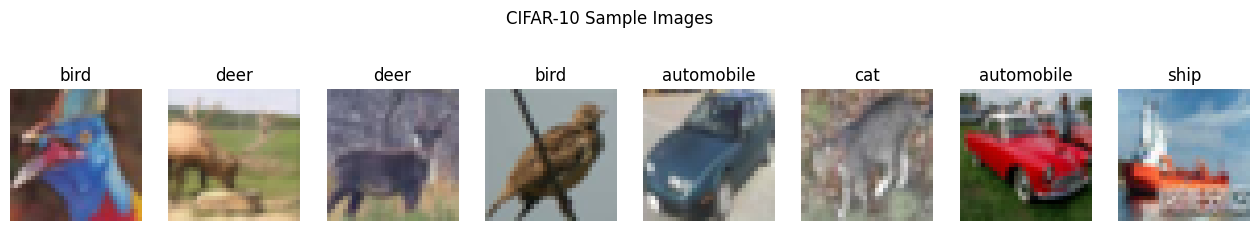

In [6]:
# Class names
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Get one batch of images
images, labels = next(iter(train_loader))

#Plot the samples

fig,axes=plt.subplots(1,8,figsize =(16,3))

for i,ax in enumerate(axes):
    img=images[i].permute(1,2,0) # (C,H,W) -> (H,W,C)
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.suptitle("CIFAR-10 Sample Images")
plt.show()

## Task 1: Architectural Design


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=4,stride=2,padding=1),  # (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2,padding=1), # (B, 64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1), # (B, 128, 4, 4)
            nn.ReLU()
        )

        self.fc=nn.Linear(128*4*4,2*latent_dim)

    def forward(self,x):
        h=self.conv(x)
        h=h.view(h.size(0),-1)
        mean,logvar = torch.chunk(self.fc(h), 2, dim=1)

        return mean, logvar


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Latent → feature map
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)

        self.deconv = nn.Sequential(
            # (B, 512, 4, 4) → (B, 256, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (B, 256, 8, 8) → (B, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (B, 128, 16, 16) → (B, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # 🔧 refinement at full resolution
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Output RGB image
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return torch.sigmoid(x)


### Generate encoder and decoder summary

In [9]:
latent_dimension=128
encoder=Encoder(latent_dimension).to(device)

summary(encoder,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,832
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]         131,200
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
Total params: 690,144
Trainable params: 690,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 2.63
Estimated Total Size (MB): 2.87
----------------------------------------------------------------


In [10]:
decoder=Decoder(latent_dimension).to(device)

summary(decoder,input_size=(latent_dimension,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       1,056,768
   ConvTranspose2d-2            [-1, 256, 8, 8]       2,097,408
              ReLU-3            [-1, 256, 8, 8]               0
   ConvTranspose2d-4          [-1, 128, 16, 16]         524,416
              ReLU-5          [-1, 128, 16, 16]               0
   ConvTranspose2d-6           [-1, 64, 32, 32]         131,136
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12            [-1, 3, 32, 32]           1,731
Total params: 3,885,315
Trainable params: 3,885,315
Non-trainable params: 0
---------------------------

# Task 2: Training and Performance

In [11]:
# Log probability of a diagonal Gaussian distribution
def log_norm_pdf(sample,mean,logvar,dim=1):
    log2pi=math.log(2.*math.pi)
    return torch.sum(
        -0.5*((sample-mean)**2*torch.exp(-logvar)+logvar+log2pi),dim=1
    )


# Beta Annealing method
def beta_anneal(epoch,anneal_epoch):
    """
    Linearly increase beta 0->1
    """
    return min(1.0,epoch/anneal_epoch)


#Compute the loss
def elbo_computation(encoder,decoder,x,beta):

    #Encode

    mean,logvar=encoder(x)

    #Reparametrization trick
    z = reparameterize(mean,logvar)
    

    #decode
    x_logits = decoder(z)  # (B, 3, 32, 32)

    #Reconstruction Term
    recon_loss = F.l1_loss(x_logits,  # convert to [0,1]
    x,    reduction="none")

    logpx_z=-torch.sum(recon_loss,dim=[1,2,3])

    # KL divergence terms

    logpz=log_norm_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x=log_norm_pdf(z, mean, logvar)

    #Negative ELBO (for minimization)
    # beta=1

    return -torch.mean(logpx_z + beta*(logpz - logqz_x)),z



In [12]:
def reset_metrics():
    return 0.0, 0


def update_metric(total_loss, count, loss, batch_size):
    return total_loss + loss.item() * batch_size, count + batch_size

#training function
def train_step(encoder,decoder,images,optimizer,beta):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    loss,z=elbo_computation(encoder,decoder,images,beta)
    loss.backward()
    optimizer.step()

    return loss.item()

#Function to print the generated images
def generate_and_display_images(decoder,noise):
    decoder.eval()

    with torch.no_grad():
        images= decoder(noise)
        # images = torch.sigmoid(images)  # convert logits to [0,1]

        images=images.cpu()
        n = min(images.size(0), 8) 
        fig = plt.figure(figsize=(16, 2))
        for i in range(n):
            plt.subplot(1, 8, i + 1)
            img = images[i].permute(1, 2, 0)  # (C,H,W) → (H,W,C)
            plt.imshow(img)
            plt.axis("off")

        plt.show()

#function to plot the trainin and test curve
def plot_training_curves(train_elbo,test_elbo):
    epochs = range(1, len(train_elbo) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_elbo, label="Training ELBO")
    plt.plot(epochs, test_elbo, label="Test ELBO")

    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.title("VAE Training Curves")
    plt.legend()
    plt.grid(True)
    plt.show()



In [13]:
def train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dim,device):

    train_elbo_history = []
    test_elbo_history = []
    
    noise1=torch.randn(8,latent_dim).to(device)

    print("\nEight random points from the latent space is made in to images before training\n")
    generate_and_display_images(decoder,noise1)

    for epoch in range(epochs):
        beta=beta_anneal(epoch,epochs)
        print(f'beta->{beta}')
        
        train_loss_sum,train_count=reset_metrics()
        test_loss_sum,test_count=reset_metrics()


        #Train
        for images,_ in train_loader:
            images=images.to(device)
            loss=train_step(encoder,decoder,images,optimizer,beta)
            train_loss_sum,train_count=update_metric(train_loss_sum,
                                                     train_count,torch.tensor(loss),
                                                     images.size(0))
            
        #Test
        encoder.eval()
        decoder.eval()
    
        with torch.no_grad():
            for images,_ in test_loader:
                images=images.to(device)
                loss,noise= elbo_computation(encoder,decoder,images,beta)
                test_loss_sum,test_count=update_metric(
                    test_loss_sum,test_count,loss,images.size(0)
                )
    
        train_elbo=train_loss_sum/train_count
        test_elbo=test_loss_sum/test_count
        train_elbo_history.append(-train_elbo)  # negative ELBO = actual ELBO
        test_elbo_history.append(-test_elbo)
    
        print(
            f"Epoch {epoch+1:03d}:",
            f"Train ELBO {-train_elbo:.3f}",
            f"Test ELBO {-test_elbo:.3f}"
        )
    
        # noise=torch.randn(8,latent_dim).to(device)
        generate_and_display_images(decoder,noise)

    print("\nThe same Eight random points from the latent space is made in to images after training\n")
    generate_and_display_images(decoder,noise1)
    plot_training_curves(train_elbo_history,test_elbo_history)
    

In [14]:
latent_dimension=512
learning_rate =1e-4
epochs =50
encoder=Encoder(latent_dimension).to(device)
decoder=Decoder(latent_dimension).to(device)

optimizer= torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)


Eight random points from the latent space is made in to images before training



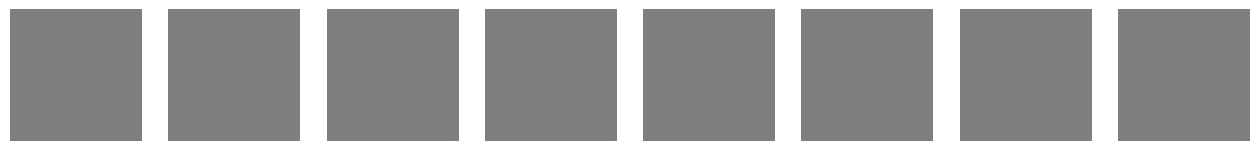

beta->0.0
Epoch 001: Train ELBO -317.210 Test ELBO -234.602


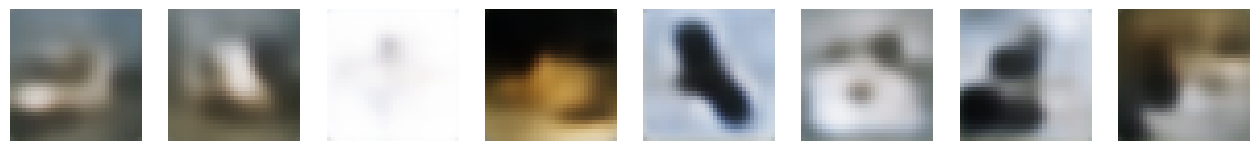

beta->0.02
Epoch 002: Train ELBO -241.188 Test ELBO -230.667


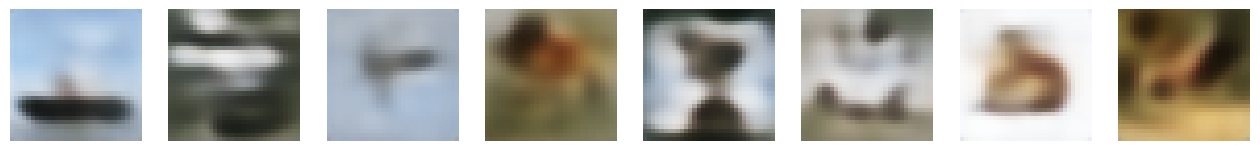

beta->0.04
Epoch 003: Train ELBO -231.648 Test ELBO -225.249


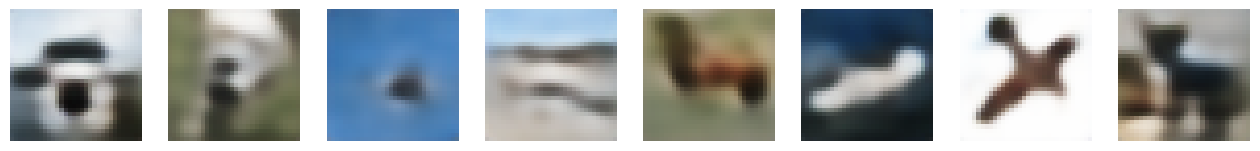

beta->0.06
Epoch 004: Train ELBO -224.533 Test ELBO -215.681


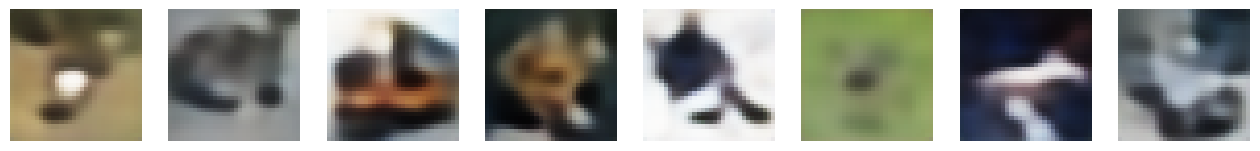

beta->0.08
Epoch 005: Train ELBO -216.235 Test ELBO -211.164


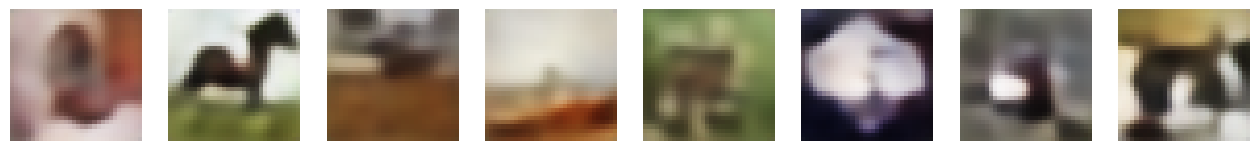

beta->0.1
Epoch 006: Train ELBO -211.871 Test ELBO -206.994


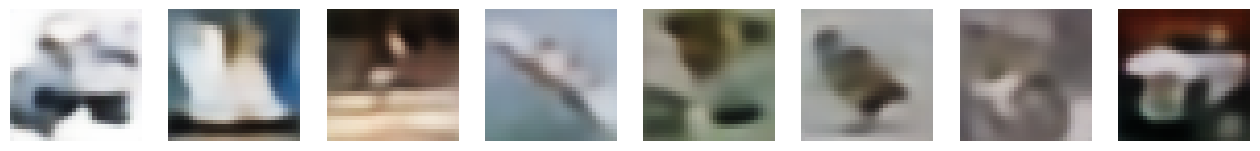

beta->0.12
Epoch 007: Train ELBO -209.180 Test ELBO -206.016


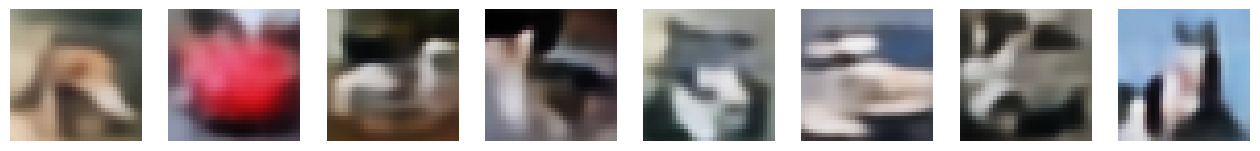

beta->0.14
Epoch 008: Train ELBO -207.835 Test ELBO -204.767


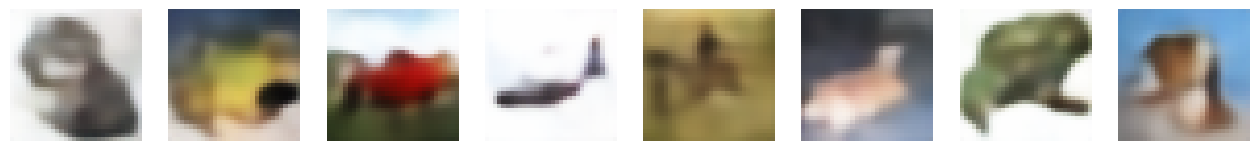

beta->0.16
Epoch 009: Train ELBO -207.699 Test ELBO -206.150


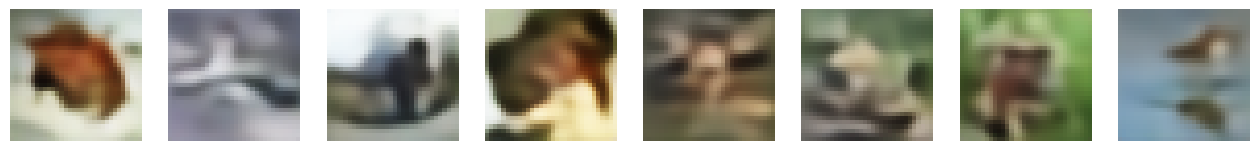

beta->0.18
Epoch 010: Train ELBO -208.340 Test ELBO -208.167


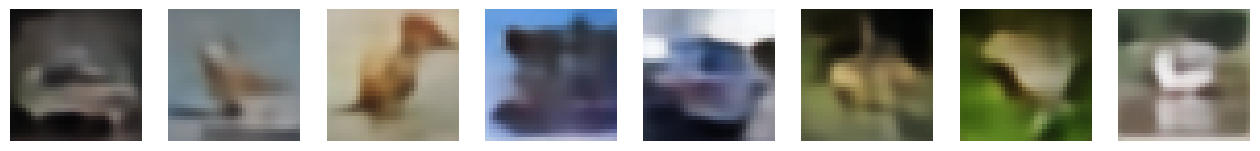

beta->0.2
Epoch 011: Train ELBO -209.563 Test ELBO -209.465


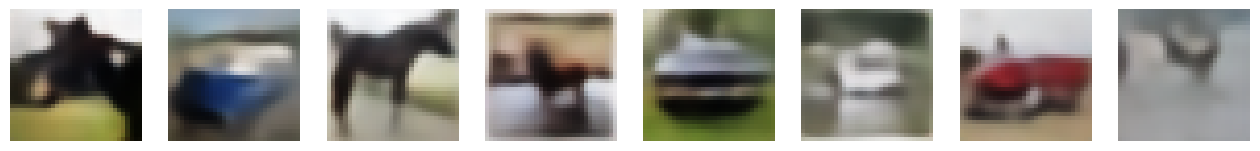

beta->0.22
Epoch 012: Train ELBO -211.082 Test ELBO -210.529


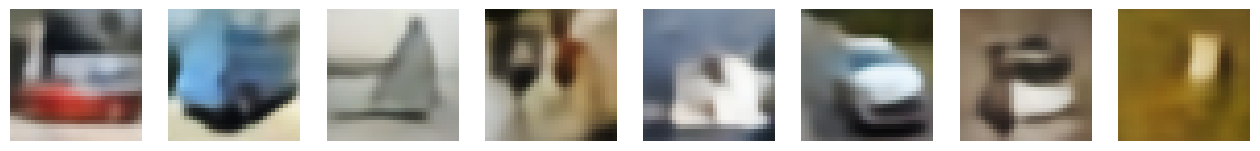

beta->0.24
Epoch 013: Train ELBO -212.858 Test ELBO -212.488


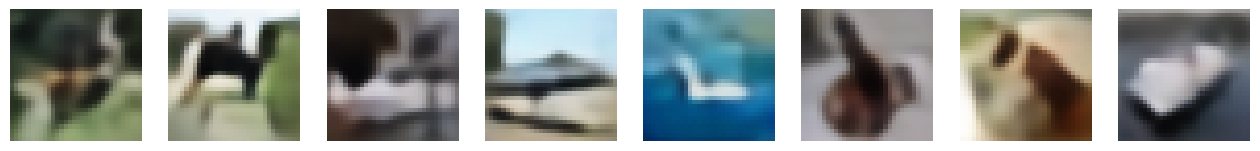

beta->0.26
Epoch 014: Train ELBO -214.862 Test ELBO -215.093


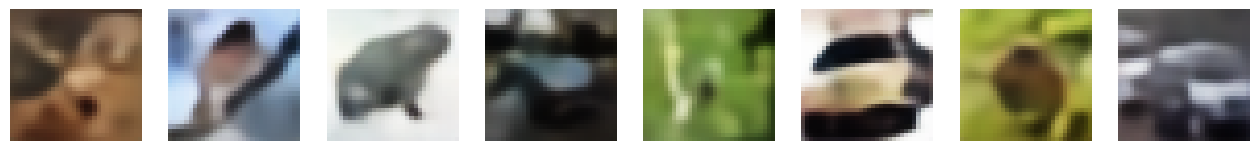

beta->0.28
Epoch 015: Train ELBO -216.887 Test ELBO -217.017


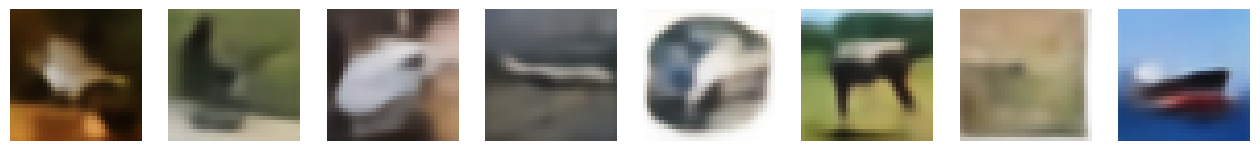

beta->0.3
Epoch 016: Train ELBO -219.104 Test ELBO -219.145


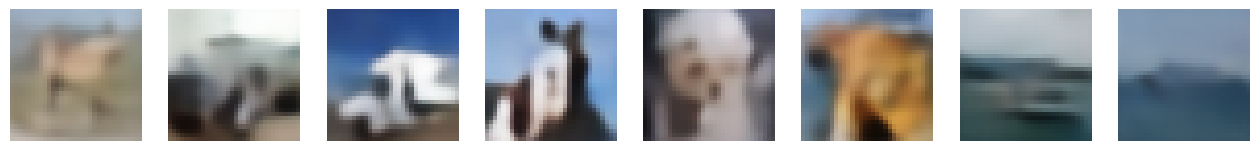

beta->0.32
Epoch 017: Train ELBO -221.303 Test ELBO -221.787


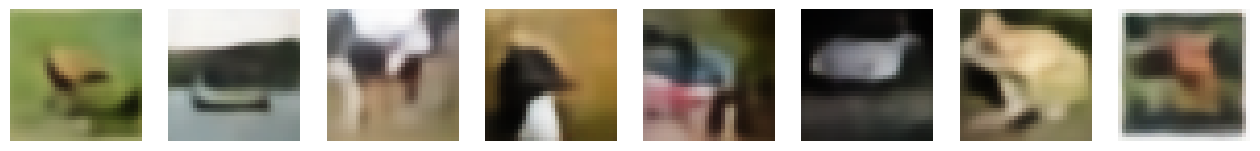

beta->0.34
Epoch 018: Train ELBO -223.360 Test ELBO -225.109


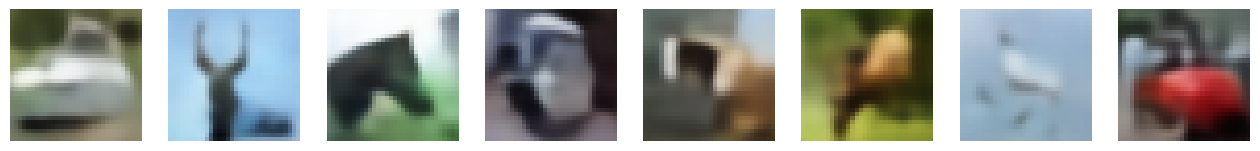

beta->0.36
Epoch 019: Train ELBO -225.488 Test ELBO -226.733


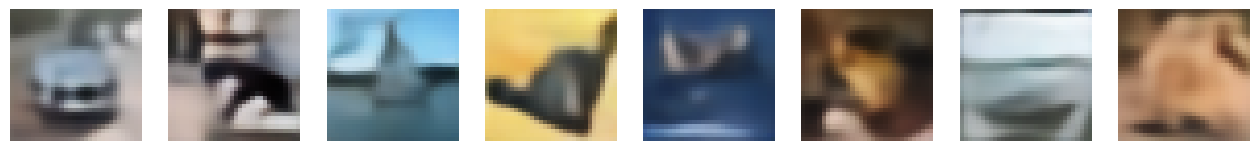

beta->0.38
Epoch 020: Train ELBO -227.745 Test ELBO -230.087


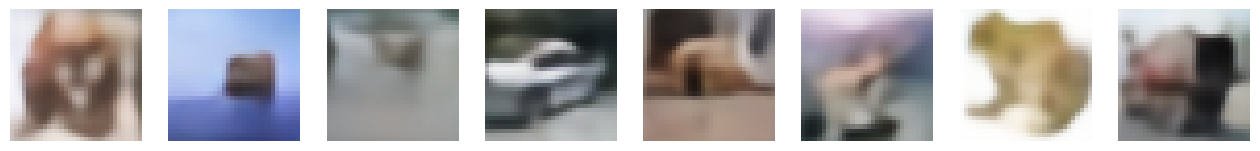

beta->0.4
Epoch 021: Train ELBO -229.827 Test ELBO -231.020


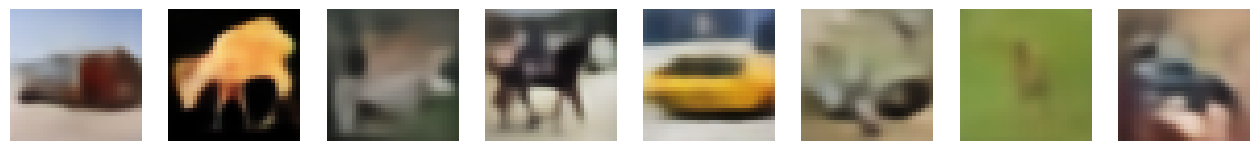

beta->0.42
Epoch 022: Train ELBO -231.913 Test ELBO -233.899


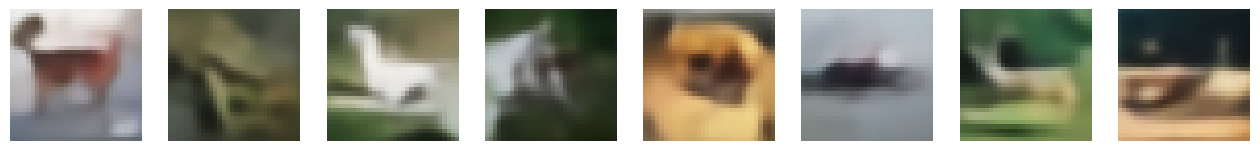

beta->0.44
Epoch 023: Train ELBO -233.953 Test ELBO -234.484


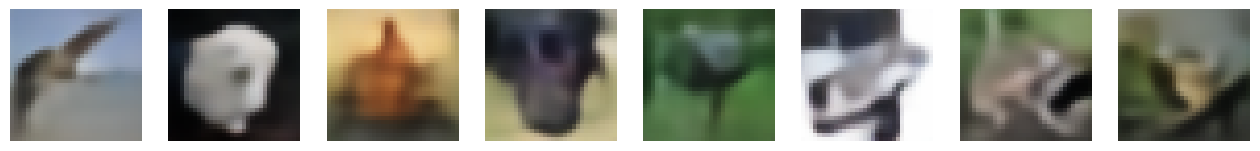

beta->0.46
Epoch 024: Train ELBO -235.959 Test ELBO -236.940


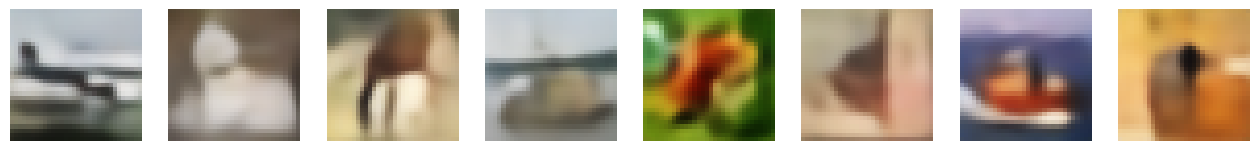

beta->0.48
Epoch 025: Train ELBO -238.023 Test ELBO -239.899


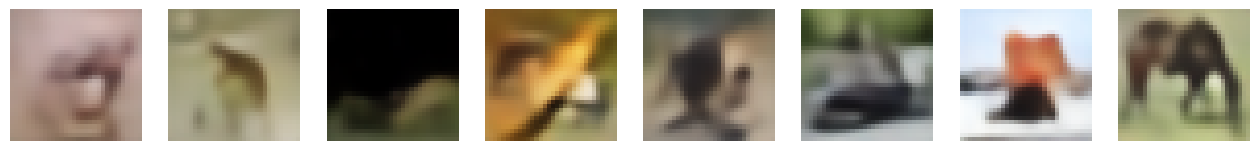

beta->0.5
Epoch 026: Train ELBO -239.899 Test ELBO -240.868


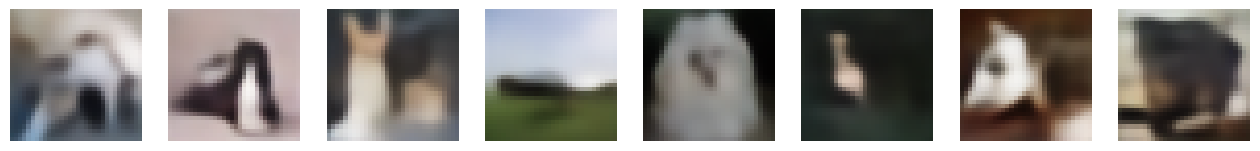

beta->0.52
Epoch 027: Train ELBO -241.798 Test ELBO -243.466


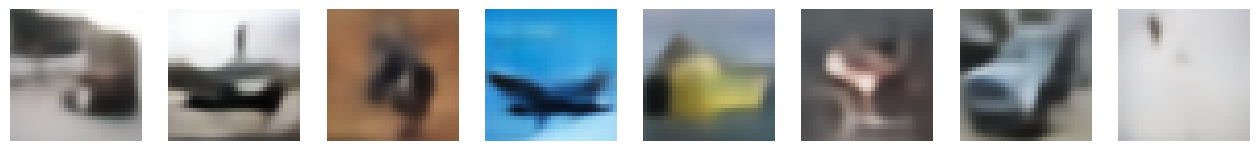

beta->0.54
Epoch 028: Train ELBO -243.741 Test ELBO -246.042


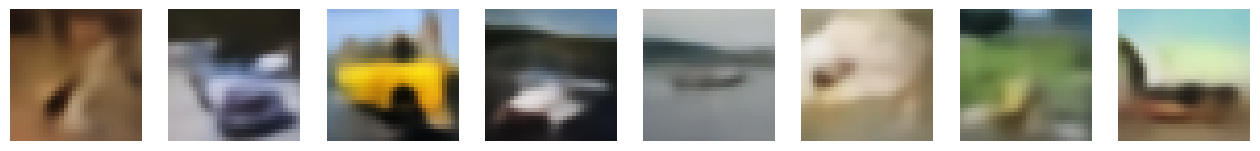

beta->0.56
Epoch 029: Train ELBO -245.494 Test ELBO -247.296


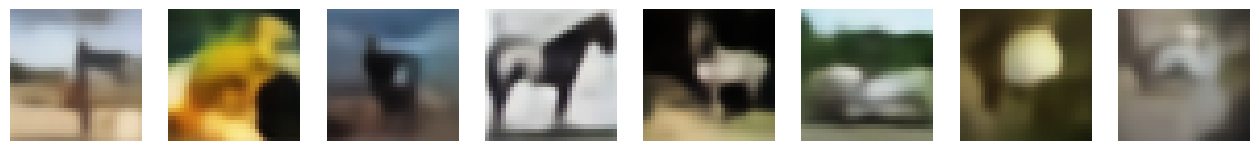

beta->0.58
Epoch 030: Train ELBO -247.332 Test ELBO -248.539


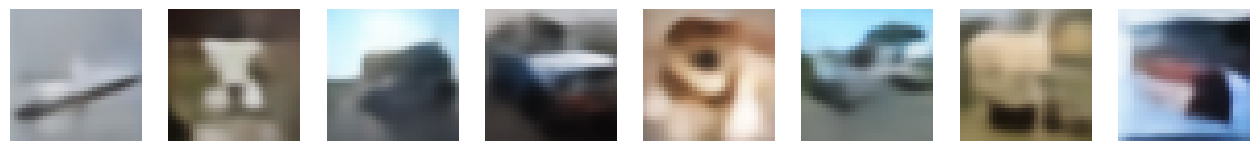

beta->0.6
Epoch 031: Train ELBO -249.137 Test ELBO -250.666


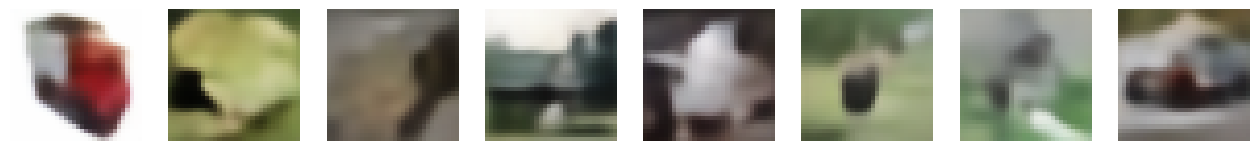

beta->0.62
Epoch 032: Train ELBO -250.892 Test ELBO -253.182


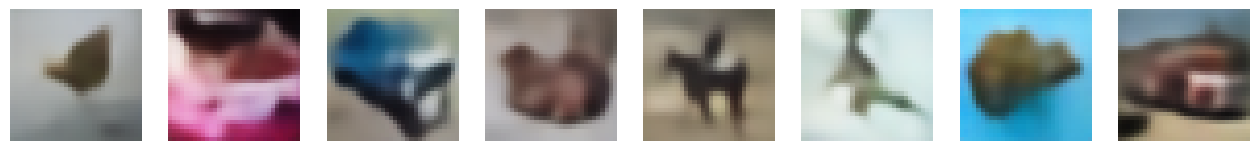

beta->0.64
Epoch 033: Train ELBO -252.572 Test ELBO -253.982


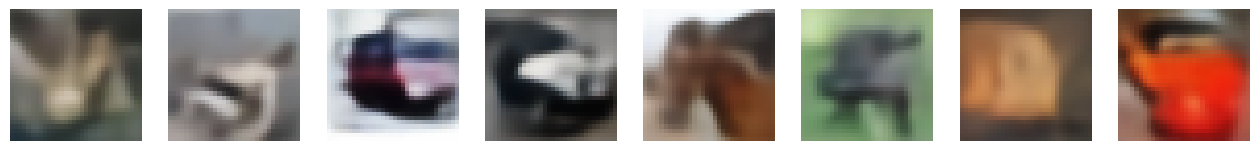

beta->0.66
Epoch 034: Train ELBO -254.249 Test ELBO -256.367


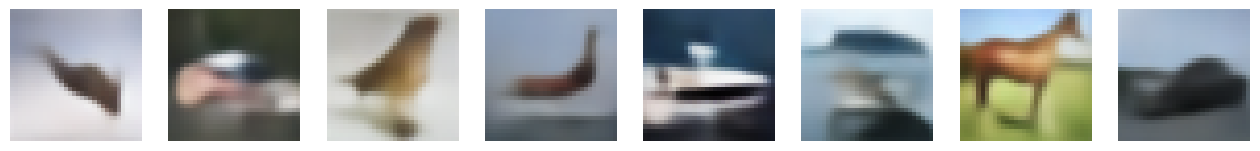

beta->0.68
Epoch 035: Train ELBO -255.870 Test ELBO -257.821


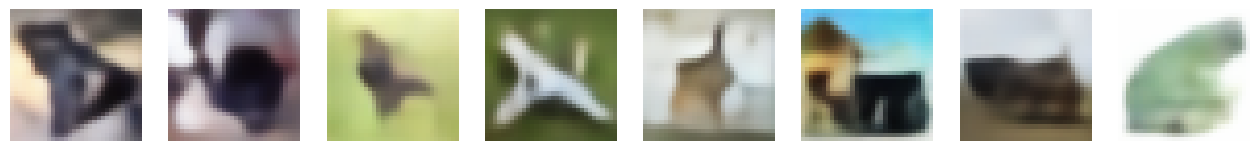

beta->0.7
Epoch 036: Train ELBO -257.393 Test ELBO -259.987


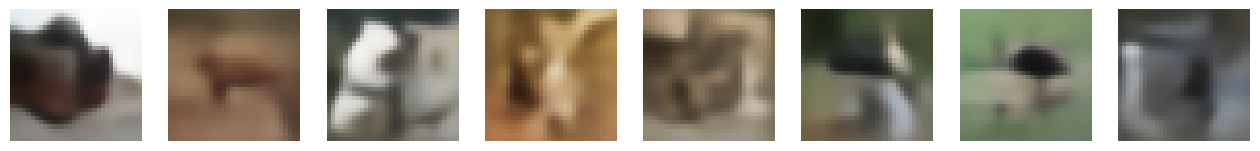

beta->0.72
Epoch 037: Train ELBO -259.006 Test ELBO -260.896


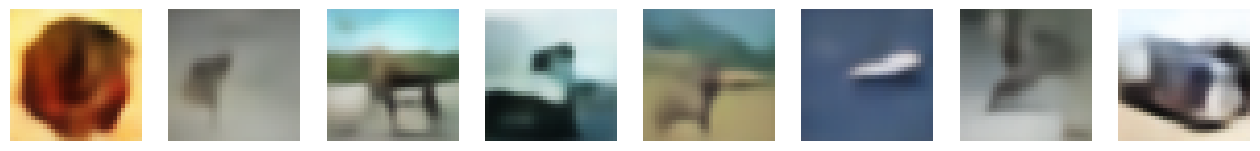

beta->0.74
Epoch 038: Train ELBO -260.542 Test ELBO -262.489


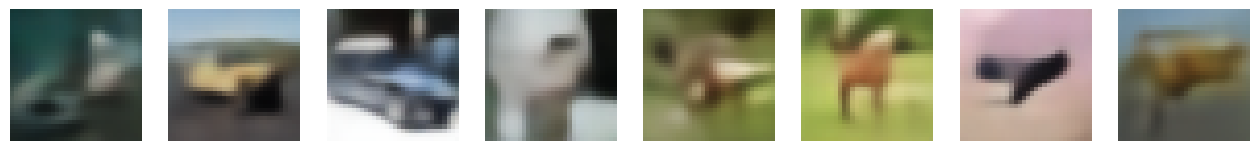

beta->0.76
Epoch 039: Train ELBO -261.984 Test ELBO -264.380


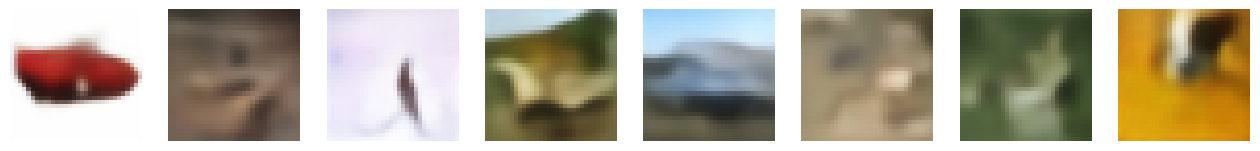

beta->0.78
Epoch 040: Train ELBO -263.484 Test ELBO -265.331


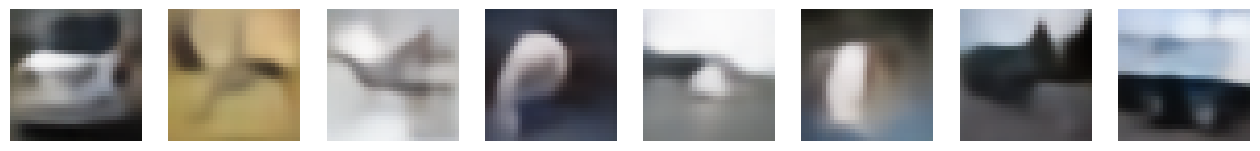

beta->0.8
Epoch 041: Train ELBO -264.964 Test ELBO -267.321


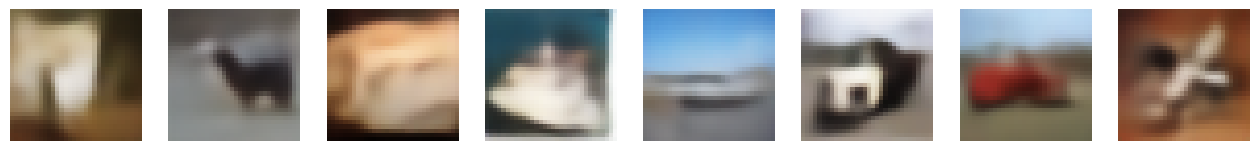

beta->0.82
Epoch 042: Train ELBO -266.405 Test ELBO -268.635


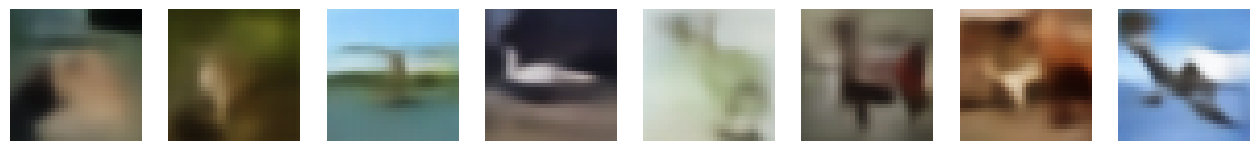

beta->0.84
Epoch 043: Train ELBO -267.722 Test ELBO -269.856


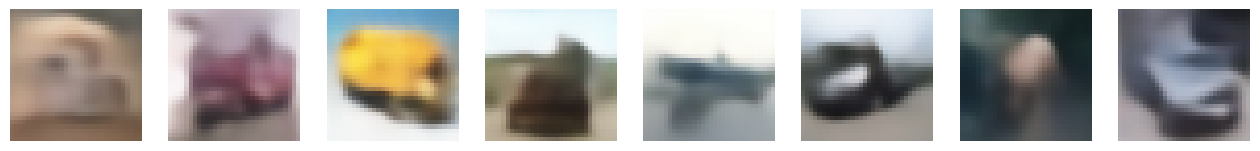

beta->0.86
Epoch 044: Train ELBO -269.138 Test ELBO -271.933


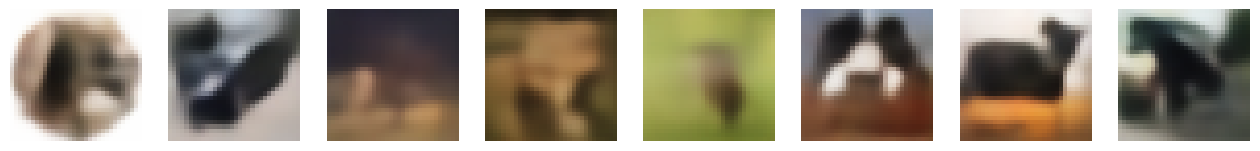

beta->0.88
Epoch 045: Train ELBO -270.464 Test ELBO -273.254


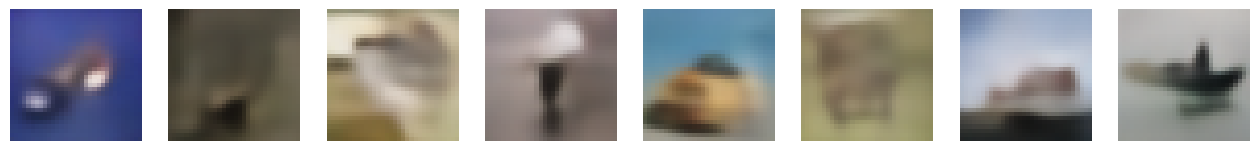

beta->0.9
Epoch 046: Train ELBO -271.775 Test ELBO -274.264


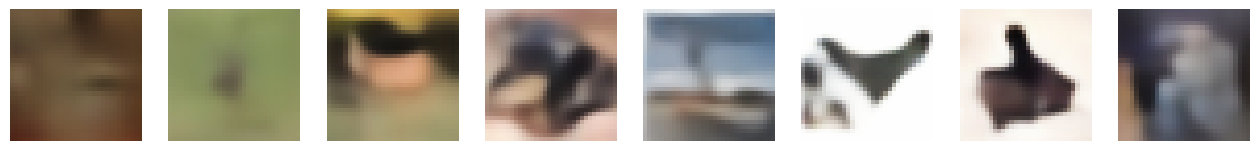

beta->0.92
Epoch 047: Train ELBO -273.031 Test ELBO -275.833


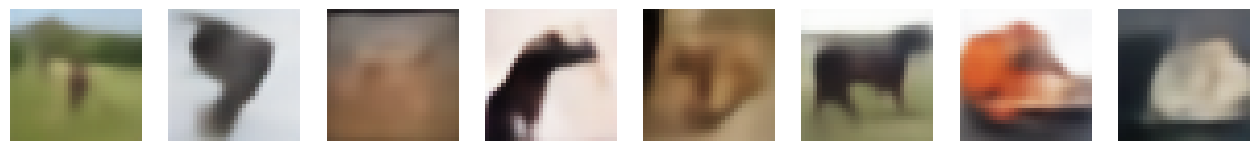

beta->0.94
Epoch 048: Train ELBO -274.343 Test ELBO -277.298


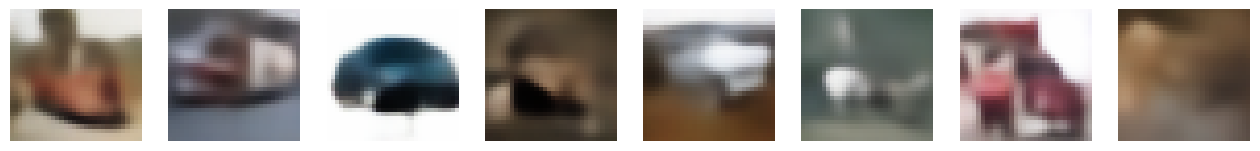

beta->0.96
Epoch 049: Train ELBO -275.587 Test ELBO -278.677


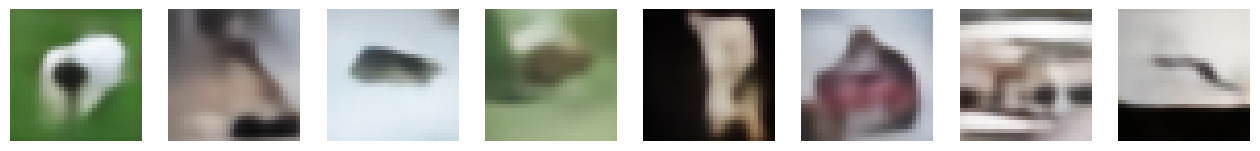

beta->0.98
Epoch 050: Train ELBO -276.811 Test ELBO -279.826


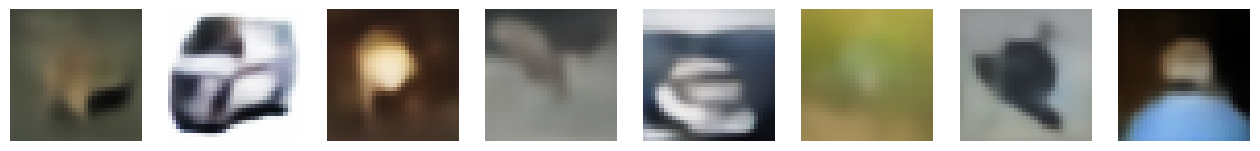


The same Eight random points from the latent space is made in to images after training



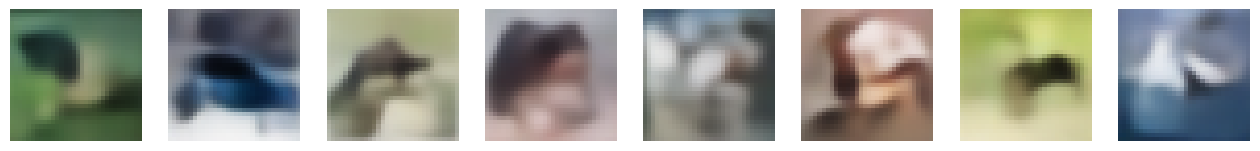

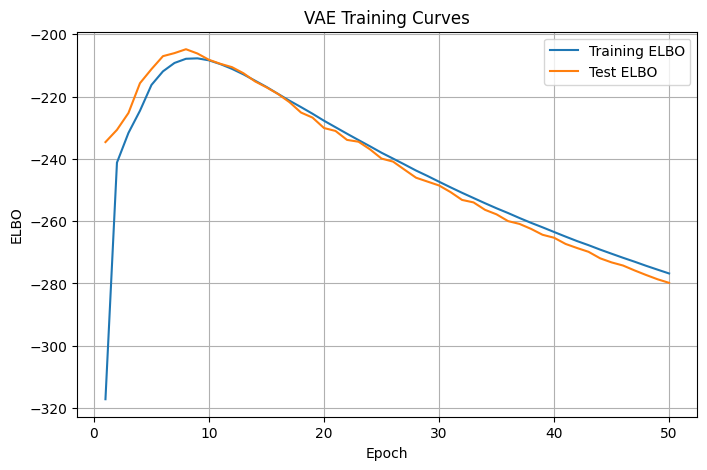

In [15]:
## Here we are using Beta annealing technique in training the model.
train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dimension,device)

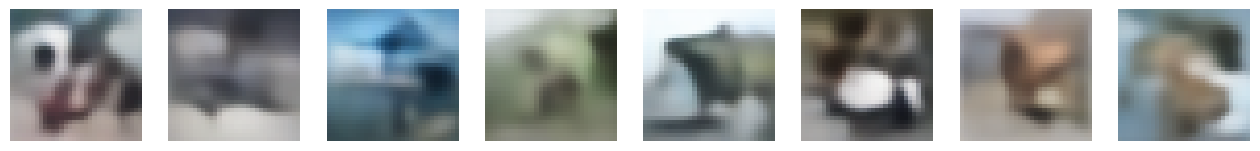

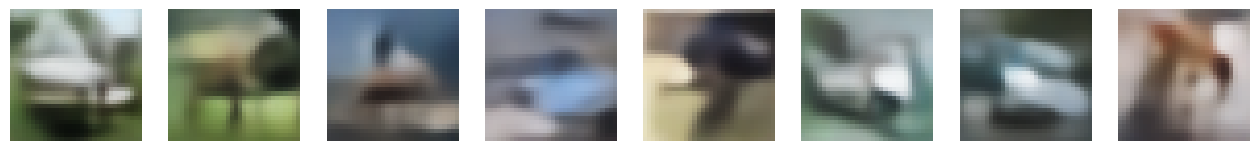

In [16]:
# A generated grid of 16 images ”dreamed up” by the model from random noise.

for i in range(2):
    noise1=torch.randn(8,latent_dimension).to(device)
    generate_and_display_images(decoder,noise1)
    

# Task 3: Latent Space Interpolation

Real images used


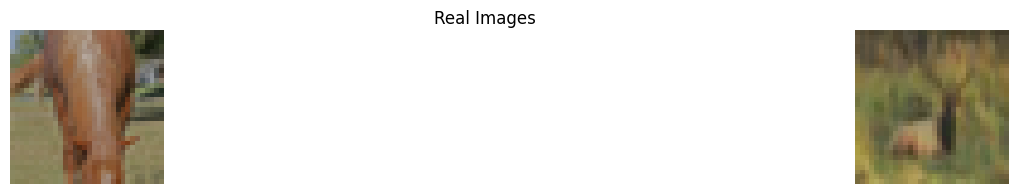

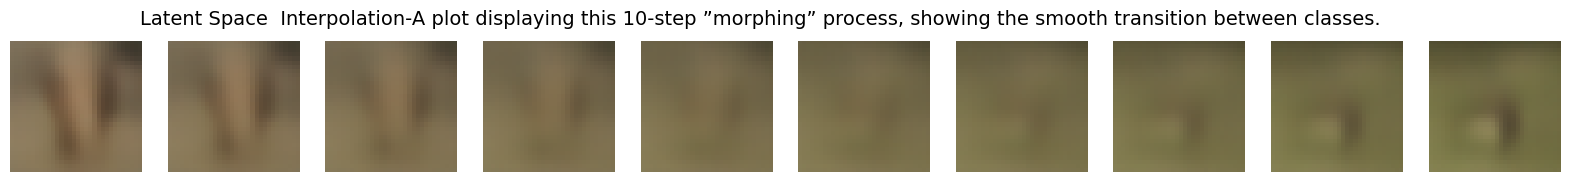

In [17]:
def interpolate_latents(z1,z2,steps=10):
    return torch.stack(
        [
            (1-alpha)*z1 + alpha*z2
            for alpha in  torch.linspace(0,1,steps)
        ]
    )

def plot_interpolation(images,real):
    images = images.cpu()

    plt.figure(figsize=(20,2))
    for i in range(images.size(0)):
        plt.subplot(1,images.size(0),i+1)
        img=images[i].permute(1,2,0)   # CHW → HWC
        plt.imshow(img)
        plt.axis("off")
    
    if real==False:
        plt.suptitle("Latent Space  Interpolation-A plot displaying this 10-step ”morphing” process, showing the smooth transition between classes.", fontsize=14)
    else:
        plt.suptitle("Real Images")
    plt.show()


encoder.eval()
decoder.eval()


images, _ = next(iter(test_loader))
images = images[:2].to(device)
print("Real images used")
plot_interpolation(images,True)


with torch.no_grad():
    mean, _ = encoder(images)
    z1, z2 = mean[0:1], mean[1:2]
    z_interp=interpolate_latents(z1,z2)
    generated_images=decoder(z_interp)
    plot_interpolation(generated_images,False)
    

## Task 4: [Advanced] β-VAE Modification

In [18]:

def train_the_vae1(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dim,beta,device):

    train_elbo_history = []
    test_elbo_history = []
    
    noise1=torch.randn(8,latent_dim).to(device)
    print("\nThe same Eight random points from the latent space is made in to images before training\n")
    generate_and_display_images(decoder,noise1)
    
    for epoch in range(epochs):
        
        
        
        train_loss_sum,train_count=reset_metrics()
        test_loss_sum,test_count=reset_metrics()


        #Train
        for images,_ in train_loader:
            images=images.to(device)
            loss=train_step(encoder,decoder,images,optimizer,beta)
            train_loss_sum,train_count=update_metric(train_loss_sum,
                                                     train_count,torch.tensor(loss),
                                                     images.size(0))
            
        #Test
        encoder.eval()
        decoder.eval()
    
        with torch.no_grad():
            for images,_ in test_loader:
                images=images.to(device)
                loss,noise= elbo_computation(encoder,decoder,images,beta)
                test_loss_sum,test_count=update_metric(
                    test_loss_sum,test_count,loss,images.size(0)
                )
    
        train_elbo=train_loss_sum/train_count
        test_elbo=test_loss_sum/test_count
        train_elbo_history.append(-train_elbo)  # negative ELBO = actual ELBO
        test_elbo_history.append(-test_elbo)
    
        print(
            f"Epoch {epoch+1:03d}:",
            f"Train ELBO {-train_elbo:.3f}",
            f"Test ELBO {-test_elbo:.3f}"
        )
    
        # noise=torch.randn(8,latent_dim).to(device)
        generate_and_display_images(decoder,noise)

    generate_and_display_images(decoder,noise1)
    print("\nThe same Eight random points from the latent space is made in to images after training\n")
    plot_training_curves(train_elbo_history,test_elbo_history)
    


beta->1

The same Eight random points from the latent space is made in to images before training



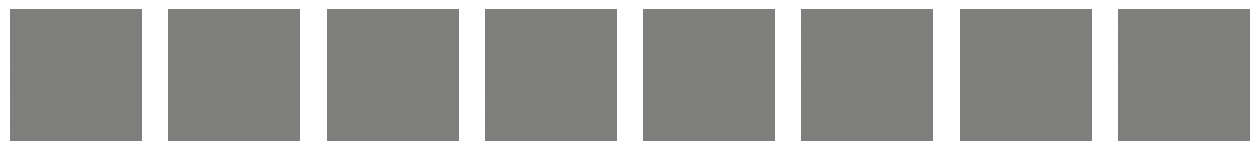

Epoch 001: Train ELBO -440.428 Test ELBO -399.941


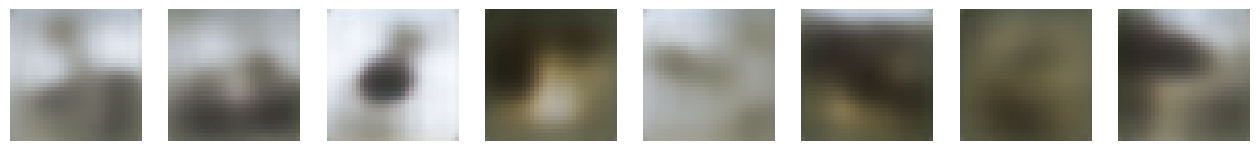

Epoch 002: Train ELBO -369.524 Test ELBO -351.998


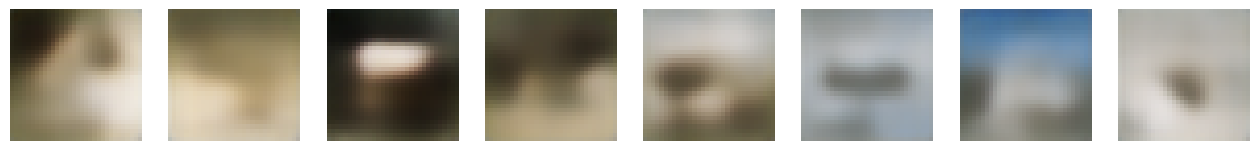

Epoch 003: Train ELBO -340.323 Test ELBO -332.790


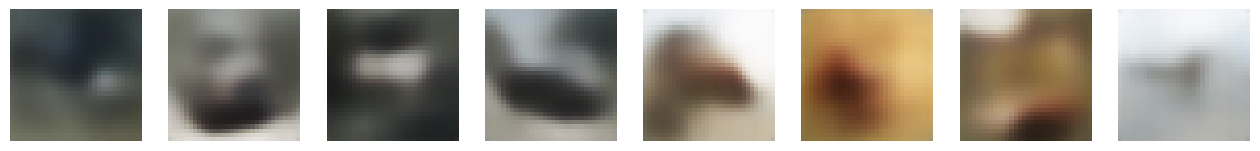

Epoch 004: Train ELBO -326.699 Test ELBO -321.896


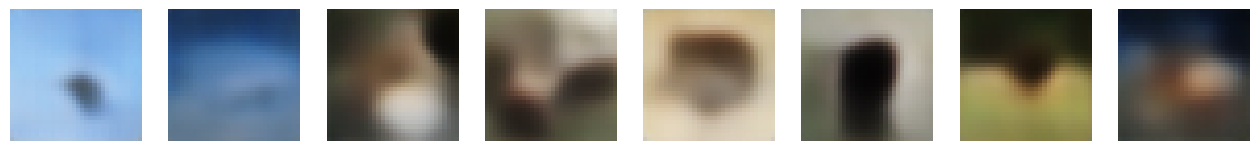

Epoch 005: Train ELBO -317.936 Test ELBO -314.357


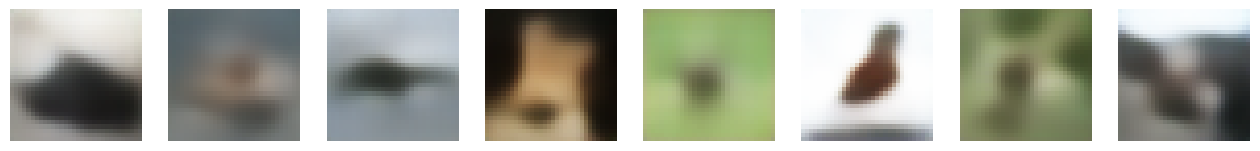

Epoch 006: Train ELBO -312.047 Test ELBO -311.059


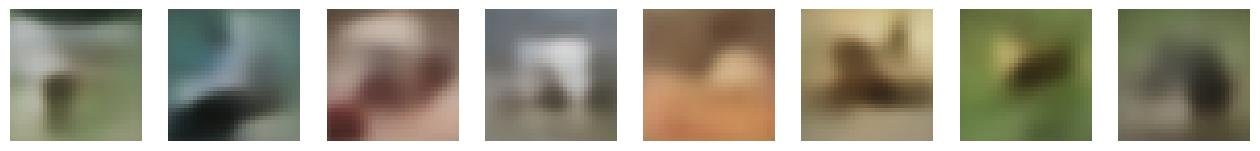

Epoch 007: Train ELBO -308.163 Test ELBO -306.973


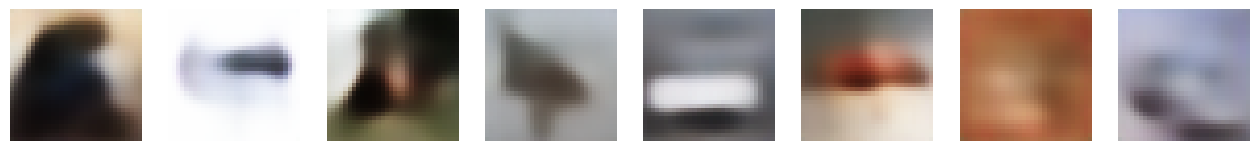

Epoch 008: Train ELBO -304.736 Test ELBO -303.467


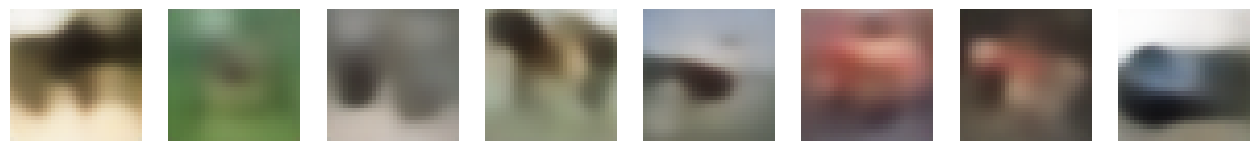

Epoch 009: Train ELBO -301.683 Test ELBO -300.571


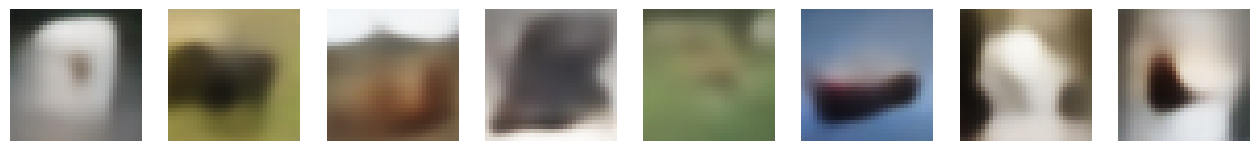

Epoch 010: Train ELBO -299.233 Test ELBO -298.802


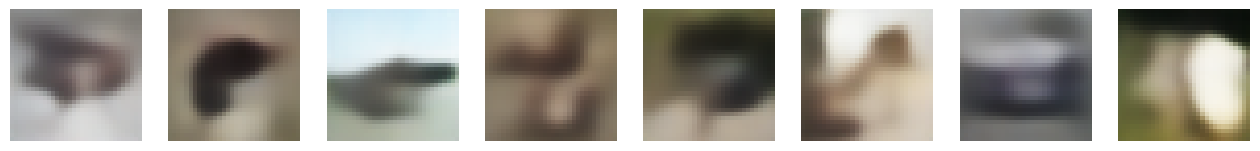

Epoch 011: Train ELBO -297.645 Test ELBO -297.554


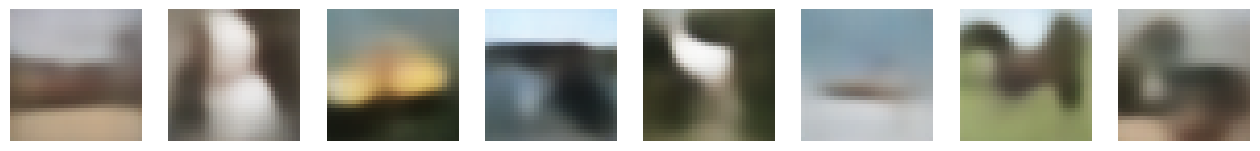

Epoch 012: Train ELBO -296.004 Test ELBO -295.954


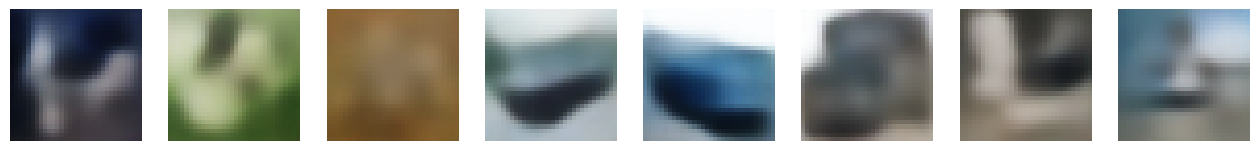

Epoch 013: Train ELBO -294.425 Test ELBO -293.912


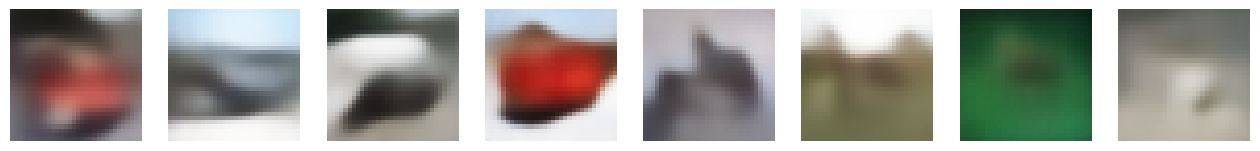

Epoch 014: Train ELBO -292.966 Test ELBO -292.911


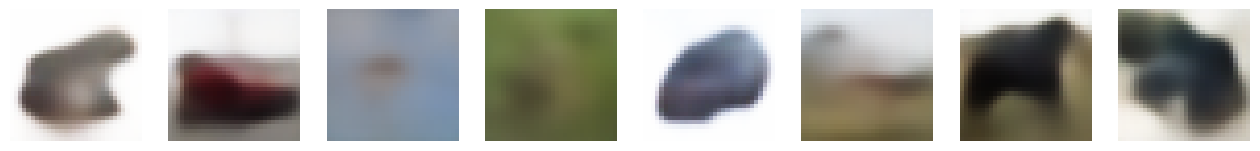

Epoch 015: Train ELBO -291.844 Test ELBO -291.247


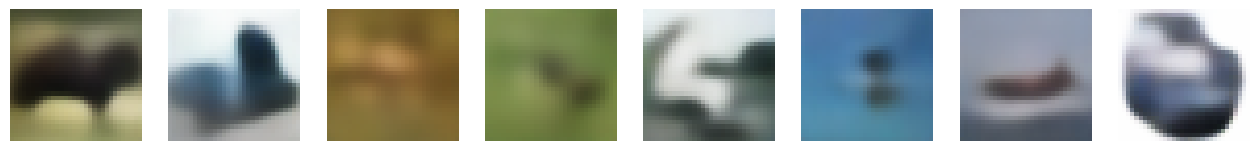

Epoch 016: Train ELBO -290.776 Test ELBO -290.803


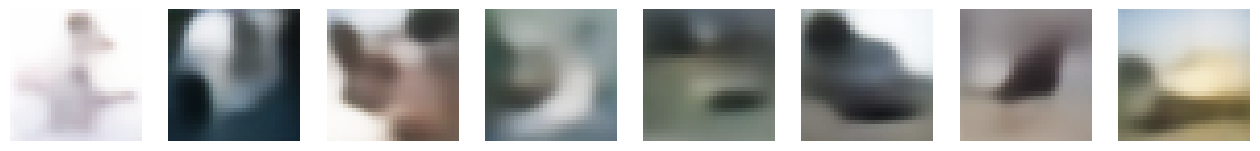

Epoch 017: Train ELBO -290.120 Test ELBO -290.325


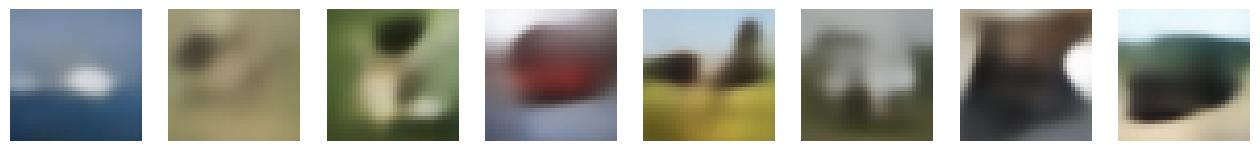

Epoch 018: Train ELBO -289.311 Test ELBO -290.412


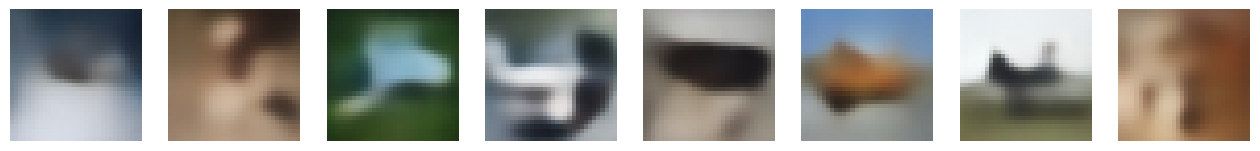

Epoch 019: Train ELBO -288.642 Test ELBO -288.697


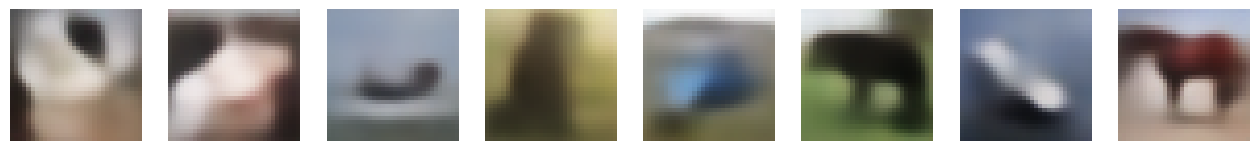

Epoch 020: Train ELBO -288.048 Test ELBO -289.599


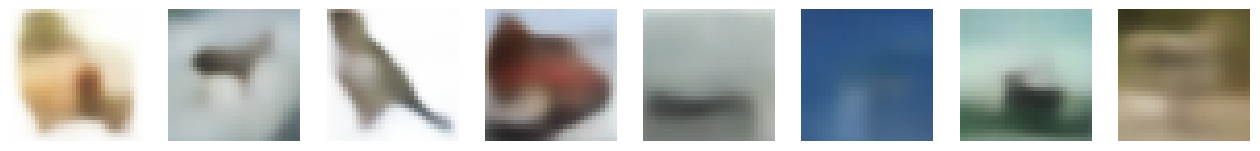

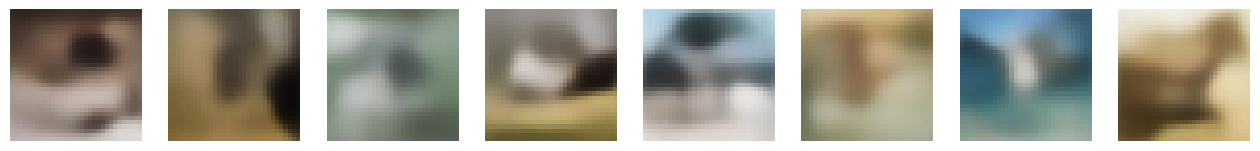


The same Eight random points from the latent space is made in to images after training



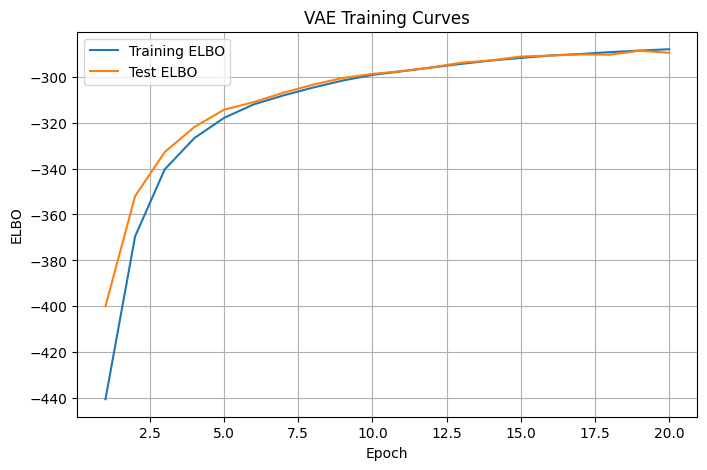

beta->2

The same Eight random points from the latent space is made in to images before training



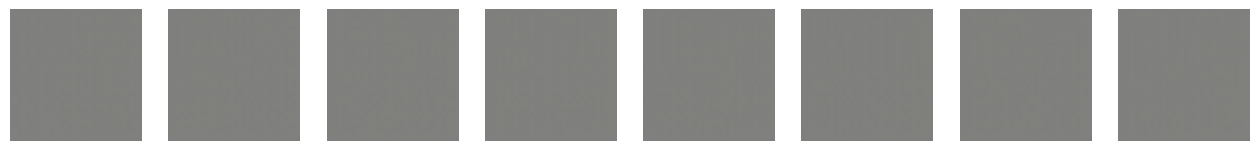

Epoch 001: Train ELBO -477.817 Test ELBO -445.516


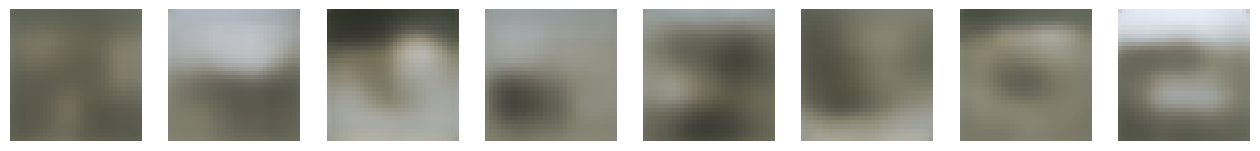

Epoch 002: Train ELBO -424.114 Test ELBO -401.736


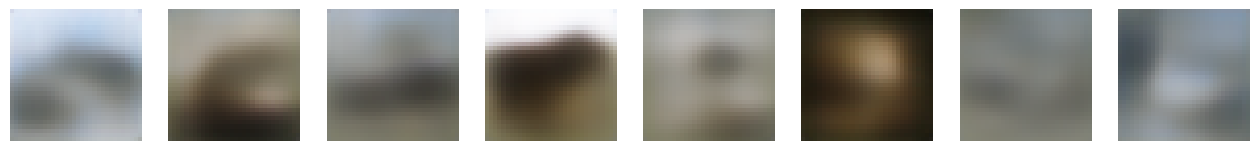

Epoch 003: Train ELBO -390.967 Test ELBO -381.750


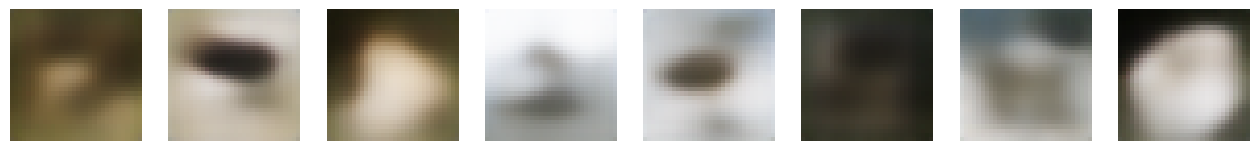

Epoch 004: Train ELBO -375.969 Test ELBO -370.206


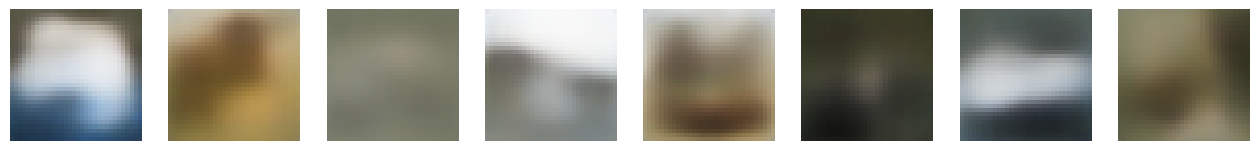

Epoch 005: Train ELBO -366.401 Test ELBO -362.766


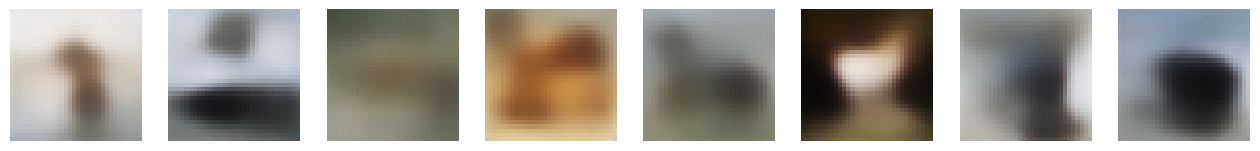

Epoch 006: Train ELBO -361.077 Test ELBO -358.728


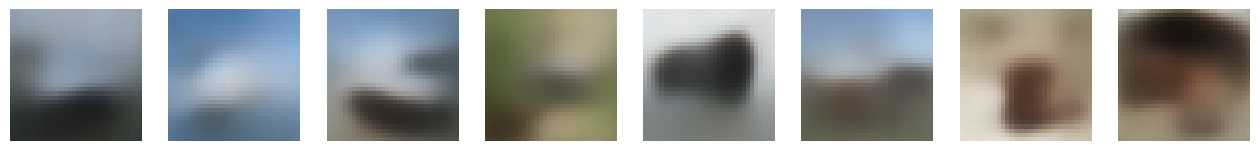

Epoch 007: Train ELBO -356.923 Test ELBO -355.779


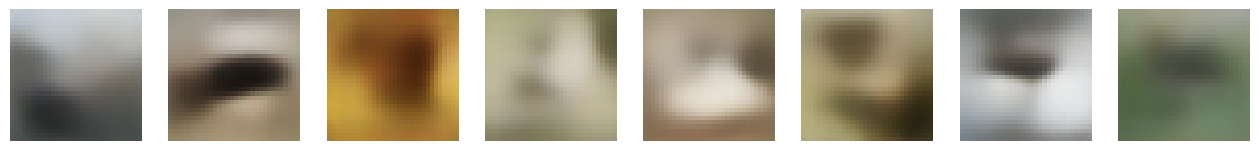

Epoch 008: Train ELBO -354.735 Test ELBO -354.390


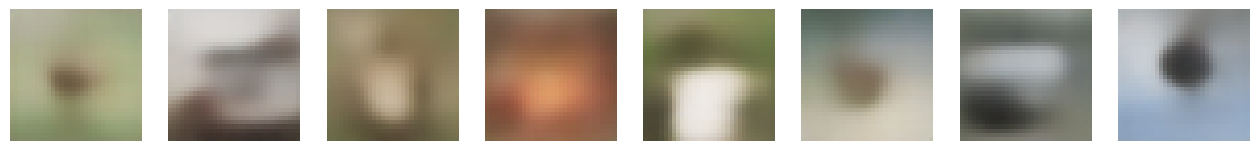

Epoch 009: Train ELBO -353.119 Test ELBO -352.898


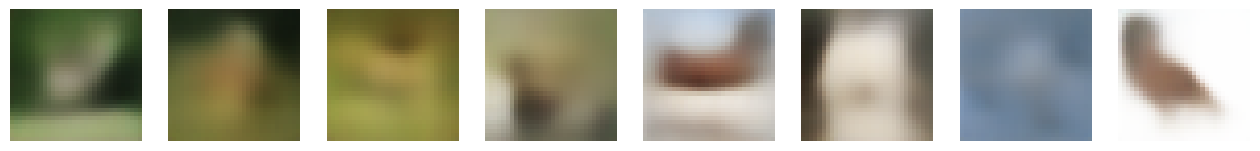

Epoch 010: Train ELBO -351.884 Test ELBO -354.353


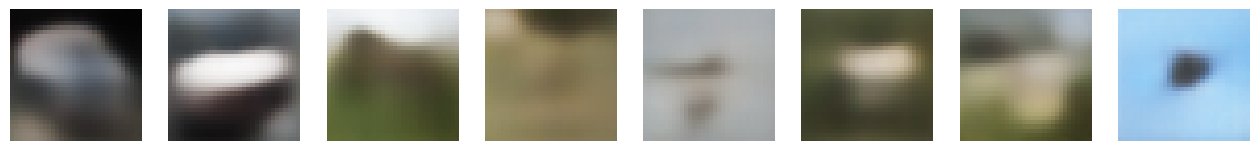

Epoch 011: Train ELBO -350.587 Test ELBO -349.899


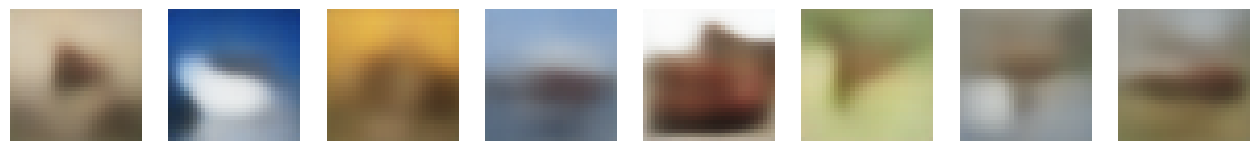

Epoch 012: Train ELBO -349.196 Test ELBO -348.895


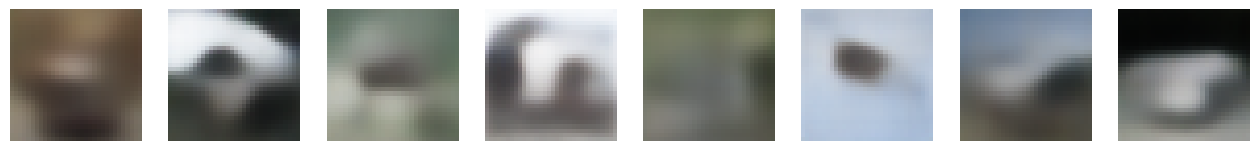

Epoch 013: Train ELBO -347.220 Test ELBO -345.864


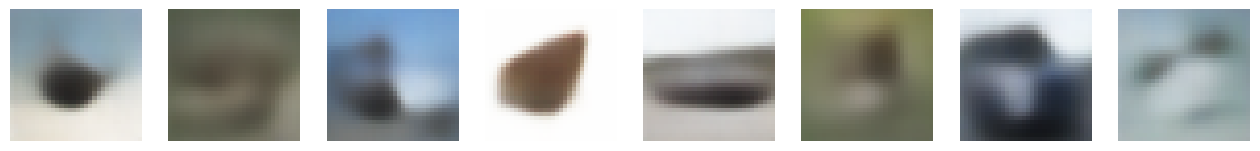

Epoch 014: Train ELBO -345.255 Test ELBO -344.122


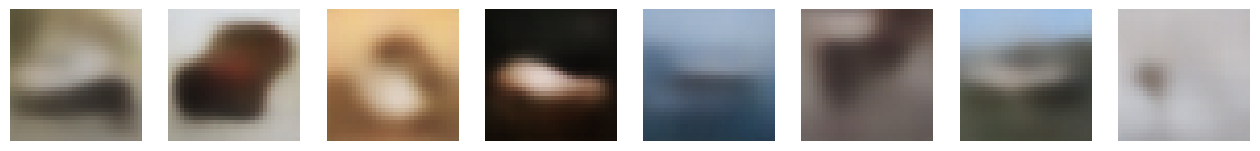

Epoch 015: Train ELBO -343.621 Test ELBO -343.366


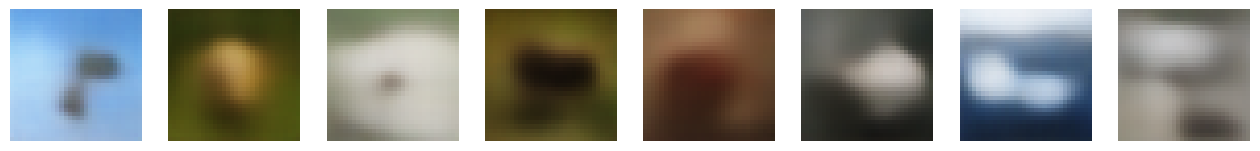

Epoch 016: Train ELBO -342.445 Test ELBO -341.870


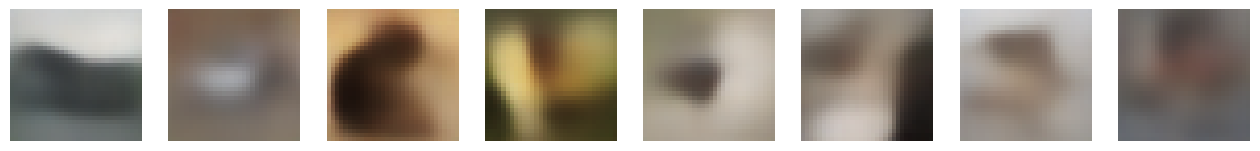

Epoch 017: Train ELBO -341.137 Test ELBO -341.990


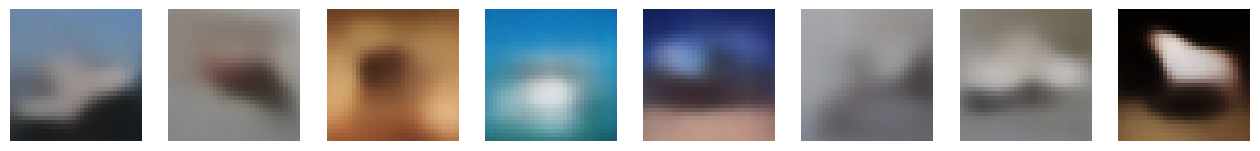

Epoch 018: Train ELBO -340.107 Test ELBO -339.796


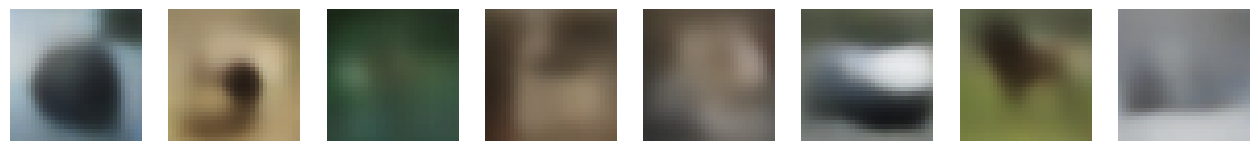

Epoch 019: Train ELBO -339.391 Test ELBO -340.187


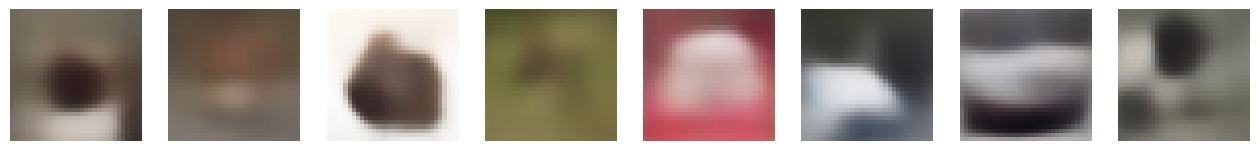

Epoch 020: Train ELBO -338.559 Test ELBO -338.825


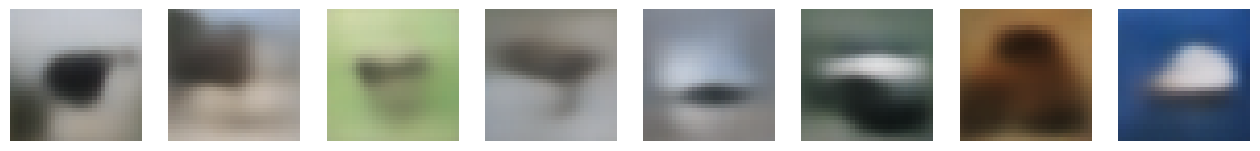

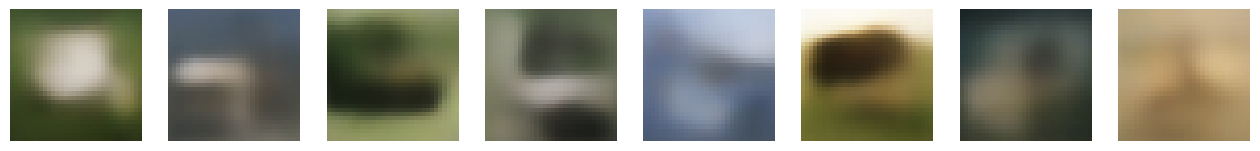


The same Eight random points from the latent space is made in to images after training



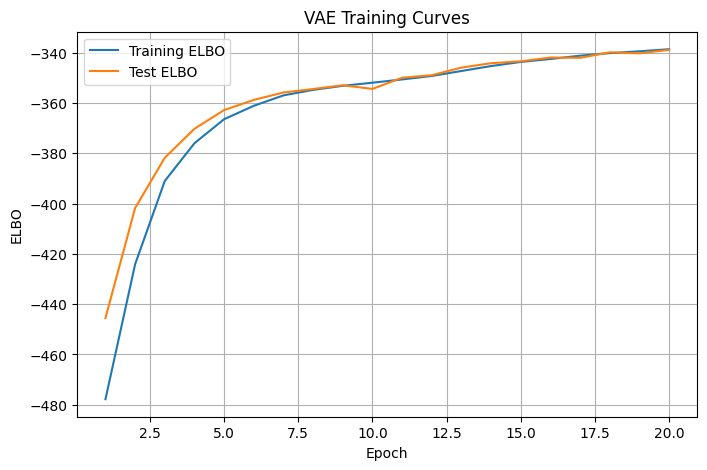

beta->3

The same Eight random points from the latent space is made in to images before training



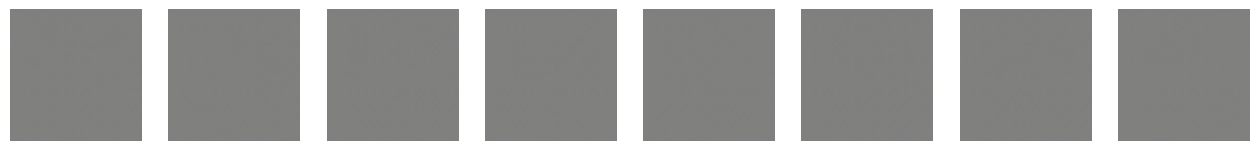

Epoch 001: Train ELBO -500.177 Test ELBO -467.743


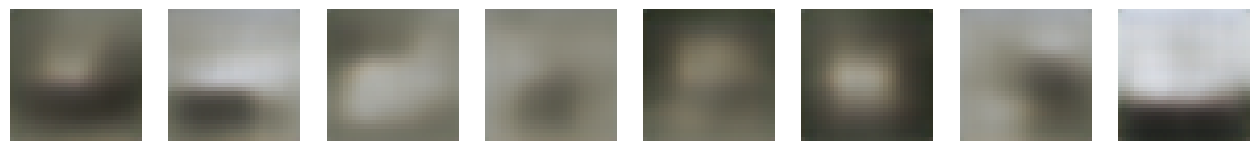

Epoch 002: Train ELBO -452.745 Test ELBO -440.607


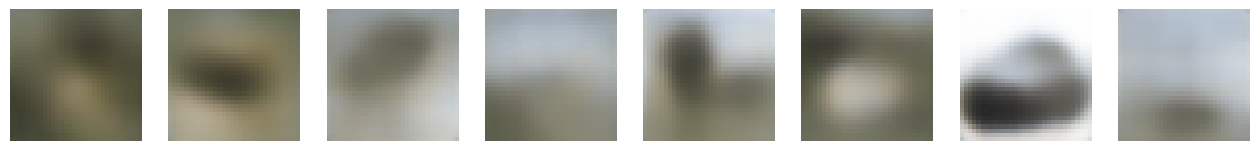

Epoch 003: Train ELBO -427.993 Test ELBO -414.115


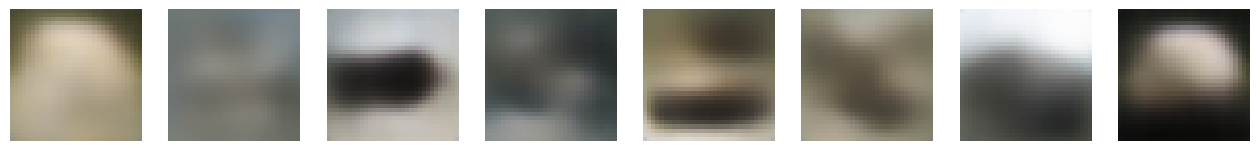

Epoch 004: Train ELBO -408.113 Test ELBO -405.248


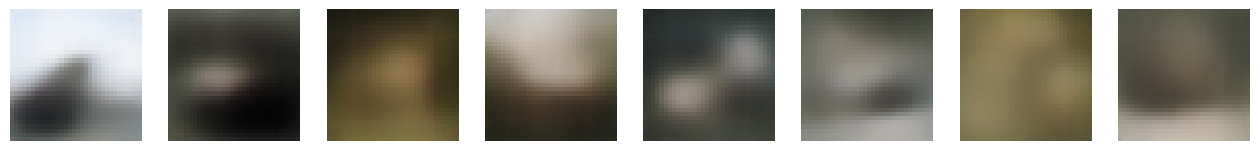

Epoch 005: Train ELBO -402.325 Test ELBO -398.444


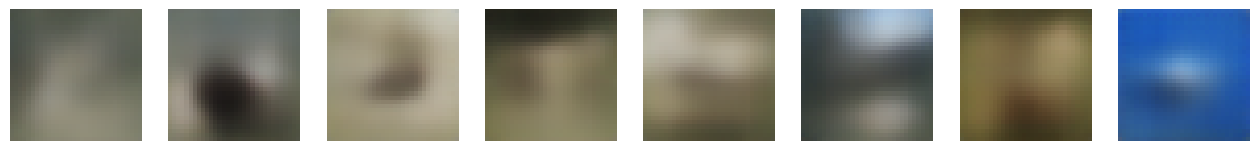

Epoch 006: Train ELBO -395.399 Test ELBO -391.491


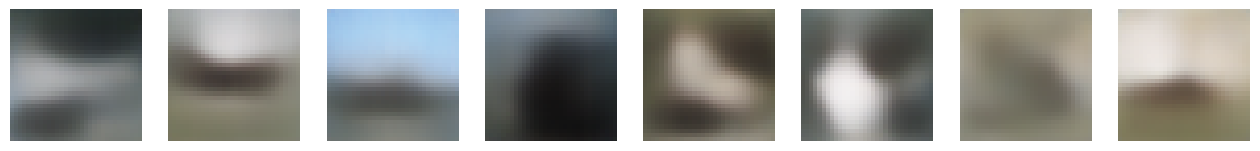

Epoch 007: Train ELBO -390.382 Test ELBO -389.386


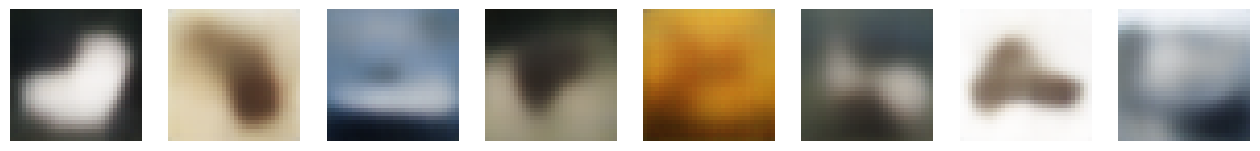

Epoch 008: Train ELBO -388.274 Test ELBO -388.504


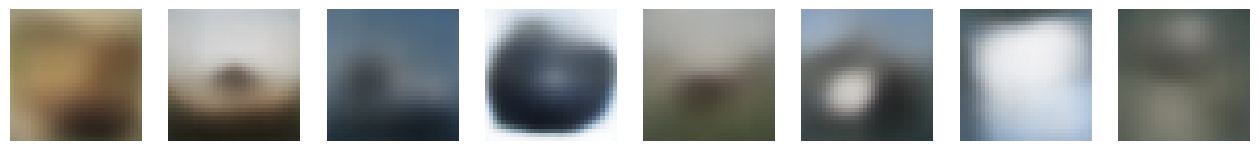

Epoch 009: Train ELBO -386.323 Test ELBO -384.627


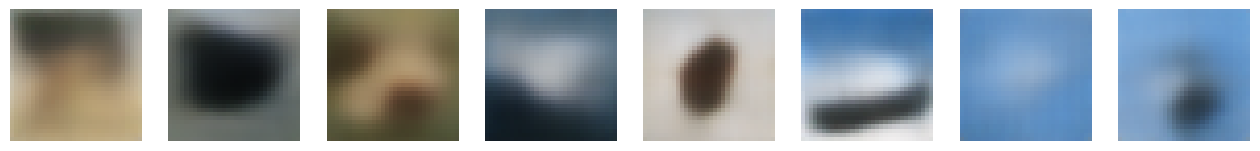

Epoch 010: Train ELBO -383.445 Test ELBO -381.497


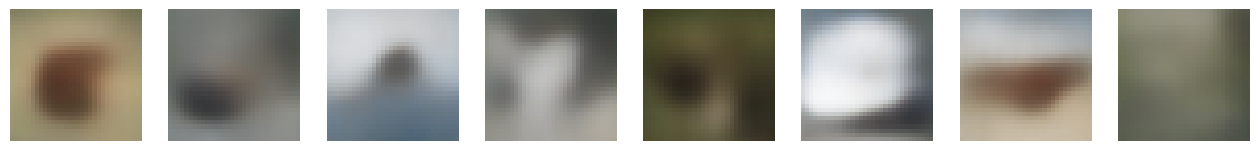

Epoch 011: Train ELBO -380.384 Test ELBO -379.603


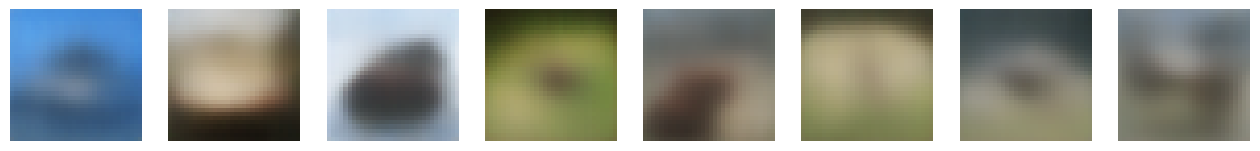

Epoch 012: Train ELBO -378.392 Test ELBO -378.215


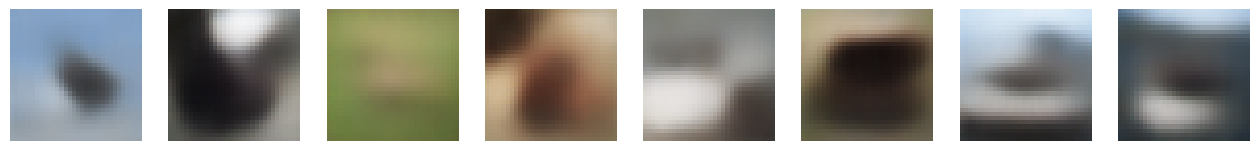

Epoch 013: Train ELBO -376.849 Test ELBO -377.546


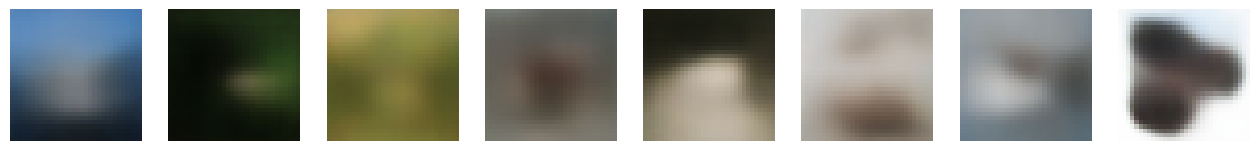

Epoch 014: Train ELBO -375.645 Test ELBO -375.561


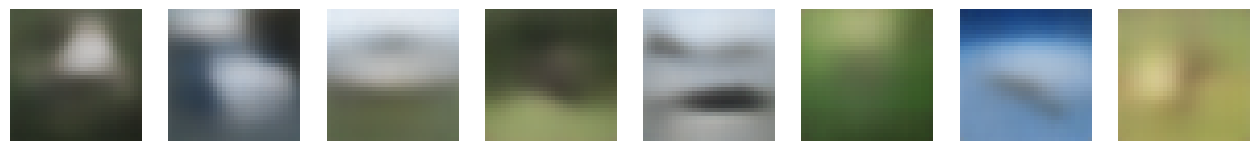

Epoch 015: Train ELBO -374.197 Test ELBO -373.490


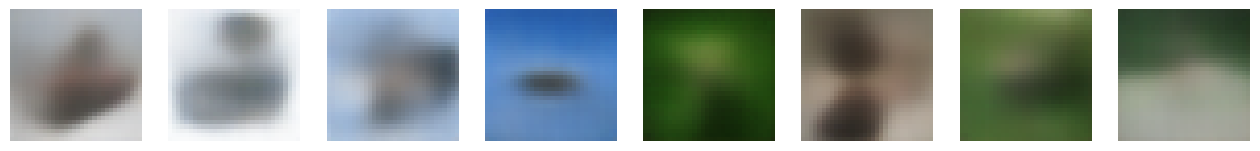

Epoch 016: Train ELBO -372.694 Test ELBO -372.551


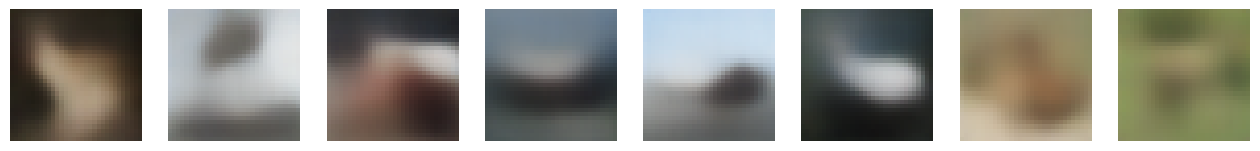

Epoch 017: Train ELBO -371.580 Test ELBO -372.287


Epoch 018: Train ELBO -370.915 Test ELBO -373.054


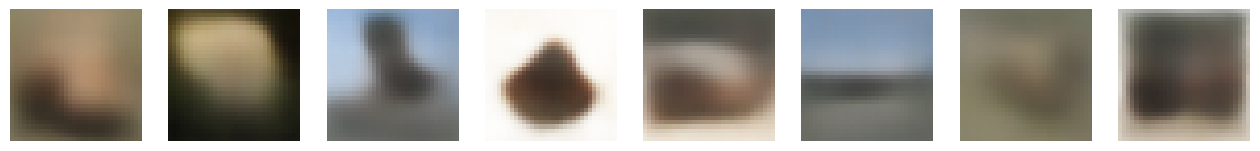

Epoch 019: Train ELBO -370.412 Test ELBO -370.410


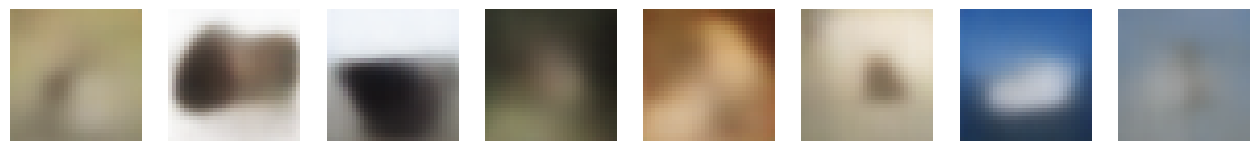

Epoch 020: Train ELBO -369.891 Test ELBO -370.185


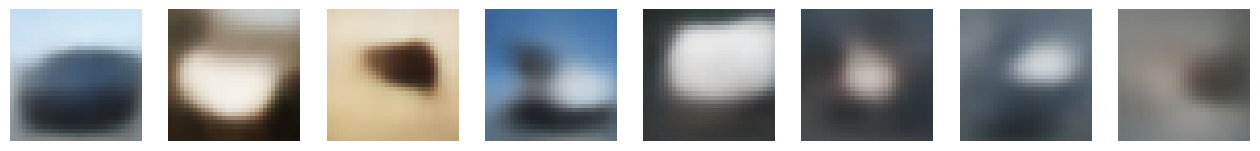

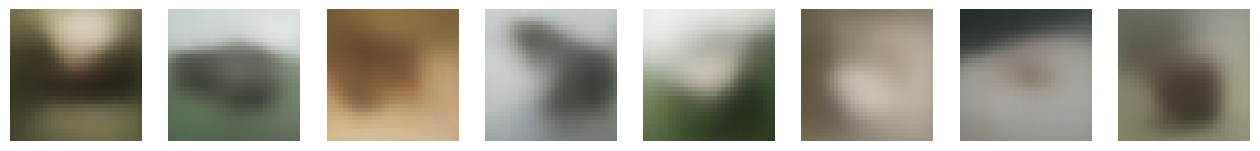


The same Eight random points from the latent space is made in to images after training



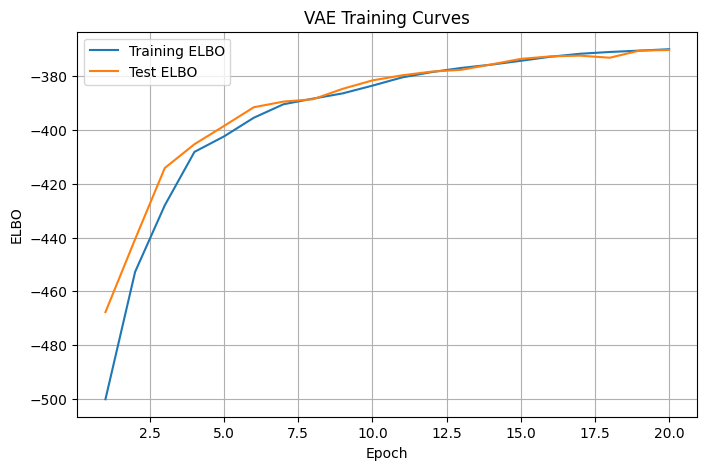

beta->4

The same Eight random points from the latent space is made in to images before training



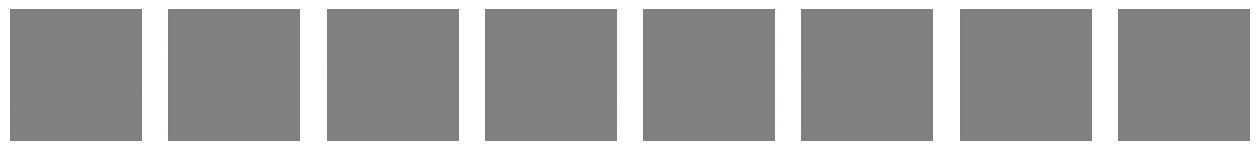

Epoch 001: Train ELBO -518.480 Test ELBO -486.215


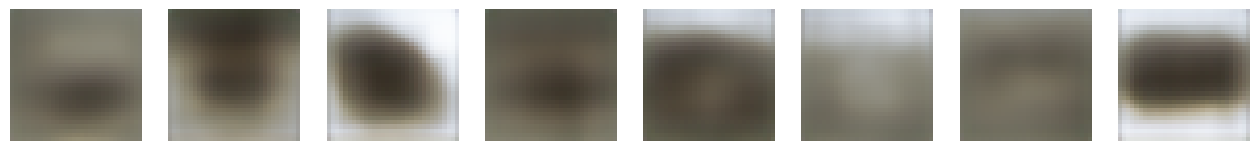

Epoch 002: Train ELBO -478.143 Test ELBO -462.378


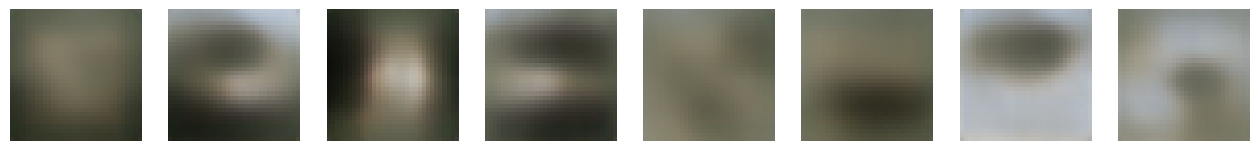

Epoch 003: Train ELBO -455.098 Test ELBO -444.597


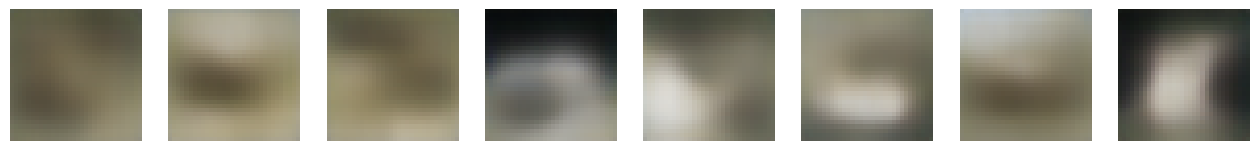

Epoch 004: Train ELBO -436.281 Test ELBO -428.243


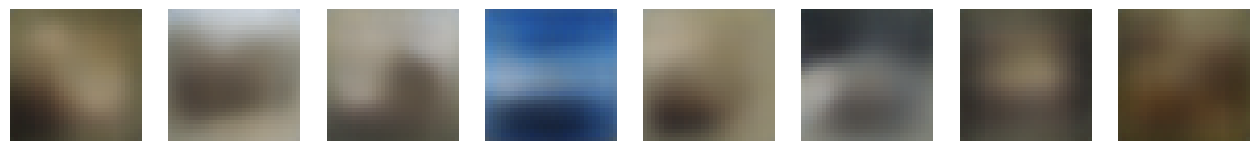

Epoch 005: Train ELBO -424.662 Test ELBO -421.243


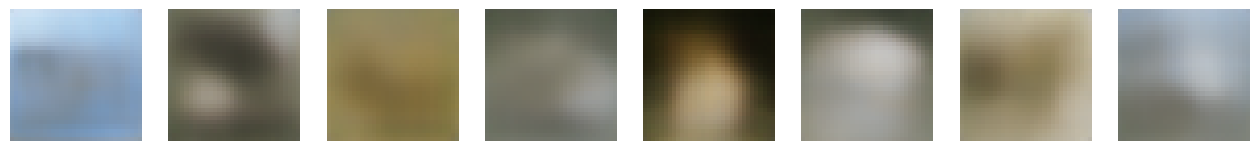

Epoch 006: Train ELBO -420.274 Test ELBO -417.618


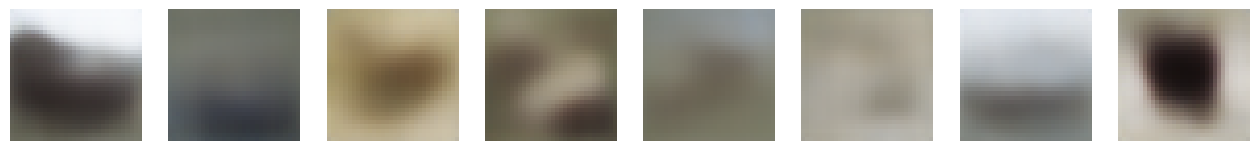

Epoch 007: Train ELBO -417.615 Test ELBO -417.213


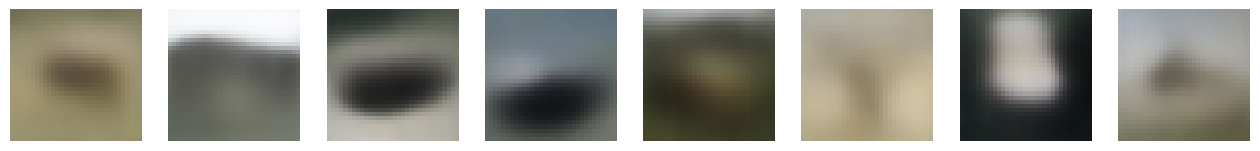

Epoch 008: Train ELBO -415.196 Test ELBO -413.092


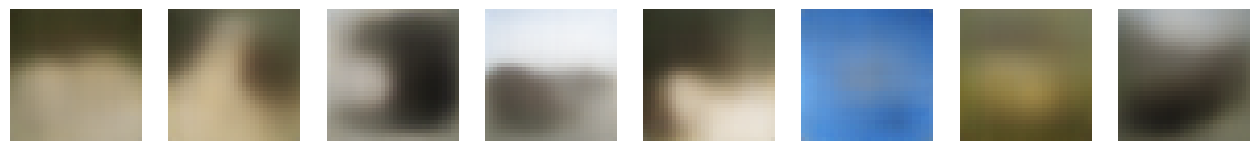

Epoch 009: Train ELBO -411.512 Test ELBO -409.398


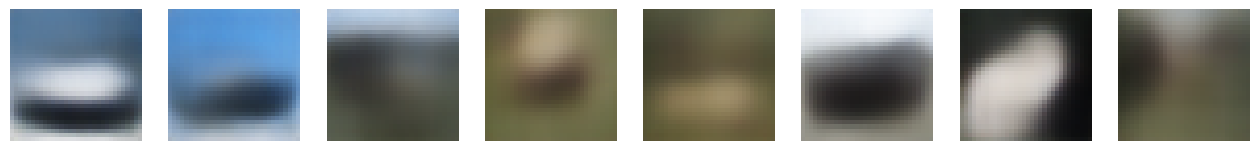

Epoch 010: Train ELBO -406.573 Test ELBO -403.327


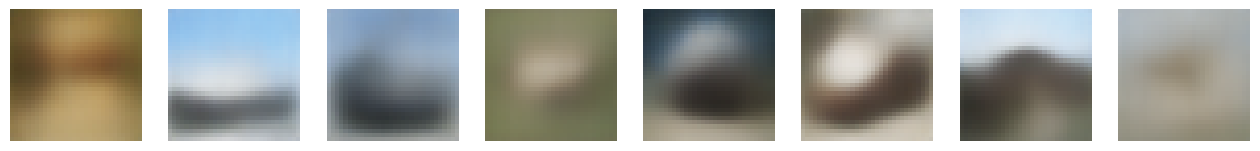

Epoch 011: Train ELBO -402.011 Test ELBO -401.303


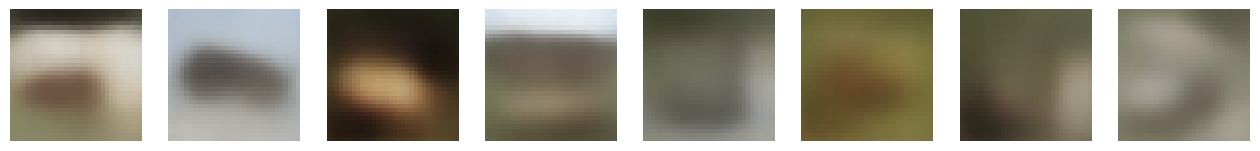

Epoch 012: Train ELBO -399.960 Test ELBO -401.513


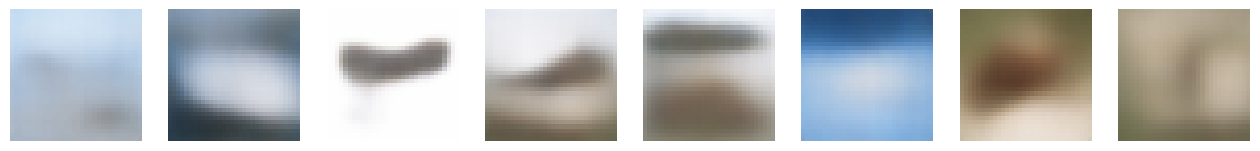

Epoch 013: Train ELBO -398.890 Test ELBO -398.759


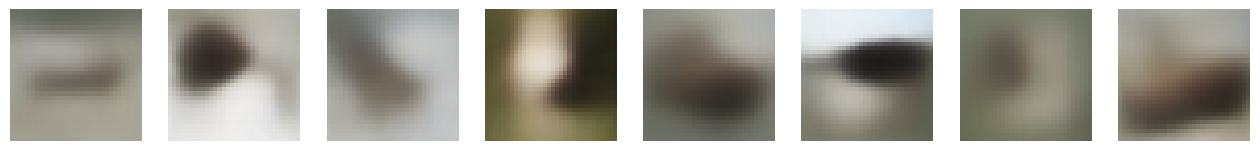

Epoch 014: Train ELBO -398.202 Test ELBO -397.818


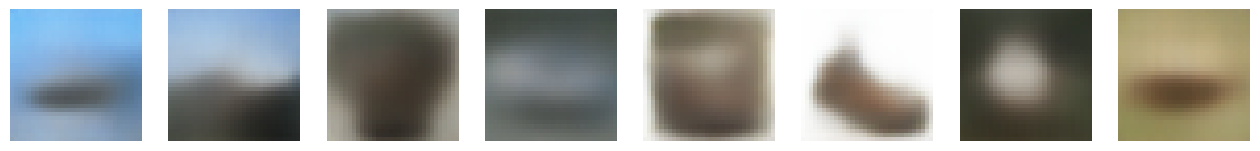

Epoch 015: Train ELBO -397.430 Test ELBO -397.747


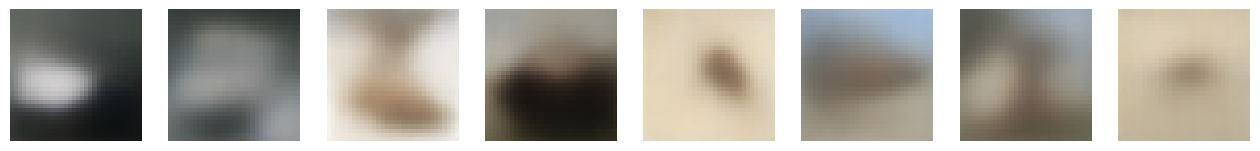

Epoch 016: Train ELBO -396.554 Test ELBO -395.892


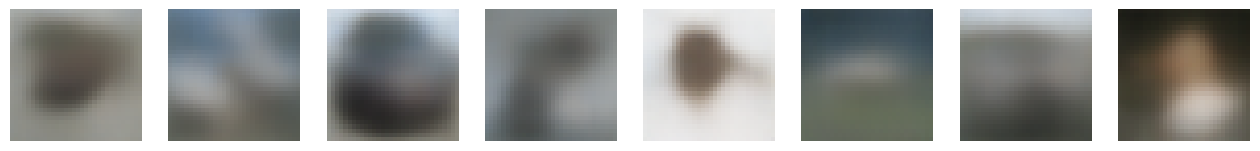

Epoch 017: Train ELBO -396.008 Test ELBO -396.104


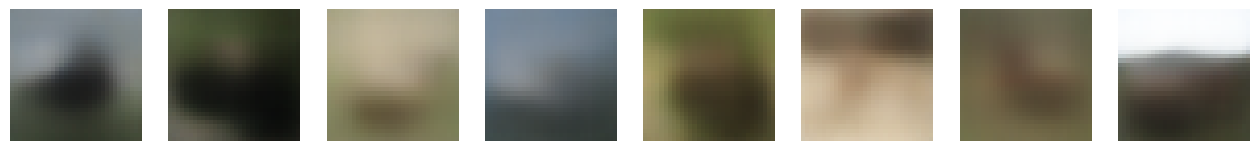

Epoch 018: Train ELBO -395.596 Test ELBO -395.492


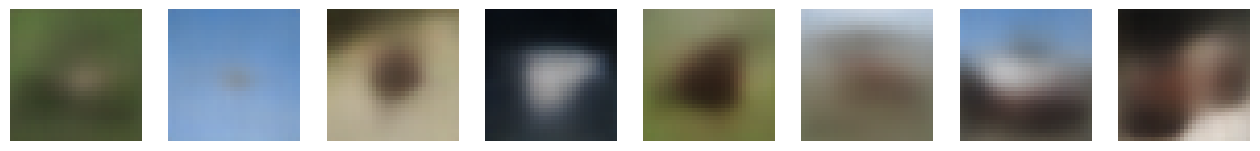

Epoch 019: Train ELBO -395.107 Test ELBO -395.069


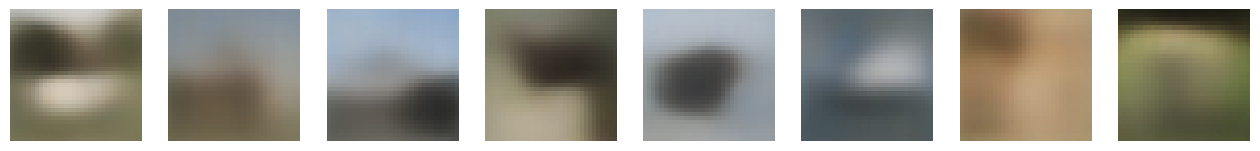

Epoch 020: Train ELBO -394.663 Test ELBO -394.737


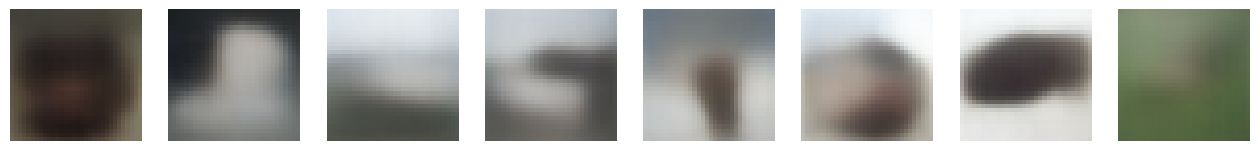

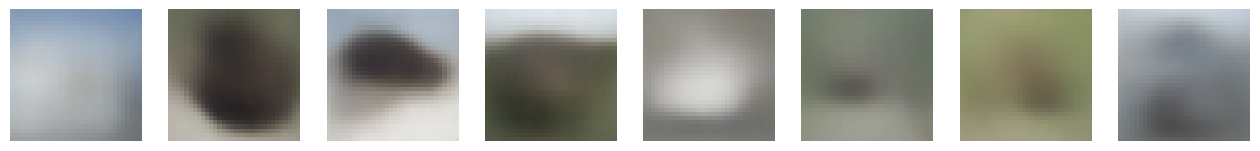


The same Eight random points from the latent space is made in to images after training



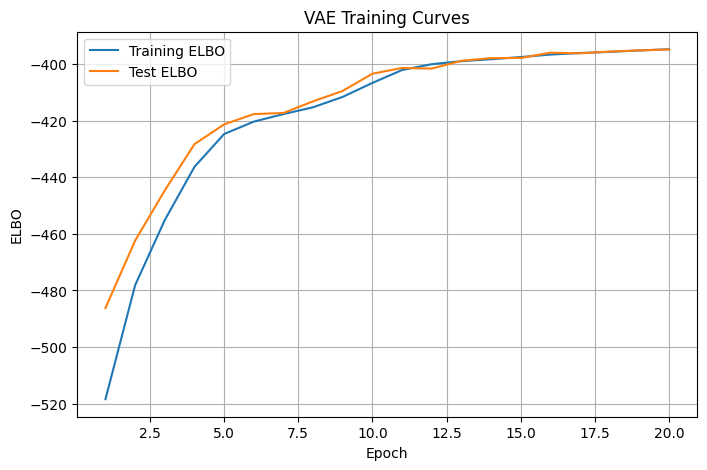

beta->5

The same Eight random points from the latent space is made in to images before training



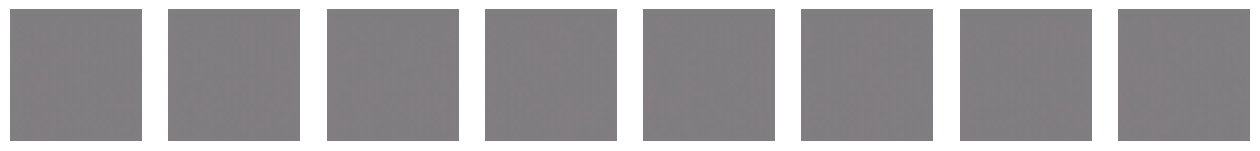

Epoch 001: Train ELBO -529.944 Test ELBO -498.694


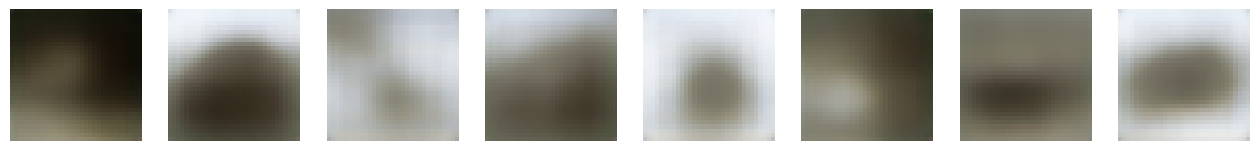

Epoch 002: Train ELBO -494.103 Test ELBO -492.450


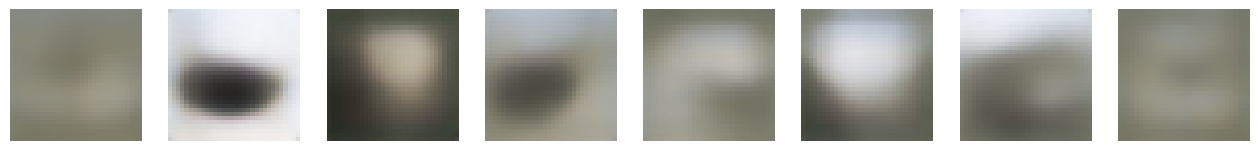

Epoch 003: Train ELBO -488.605 Test ELBO -485.479


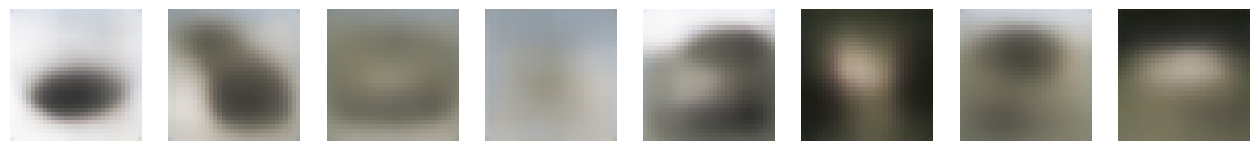

Epoch 004: Train ELBO -474.428 Test ELBO -454.840


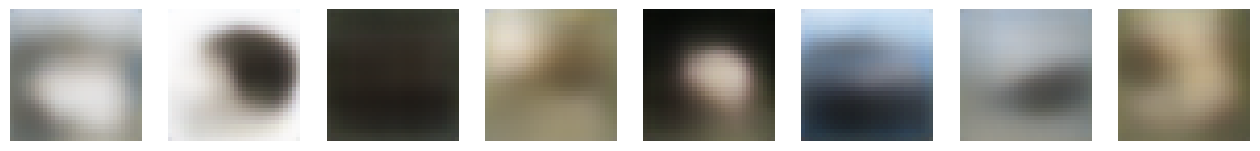

Epoch 005: Train ELBO -445.911 Test ELBO -442.095


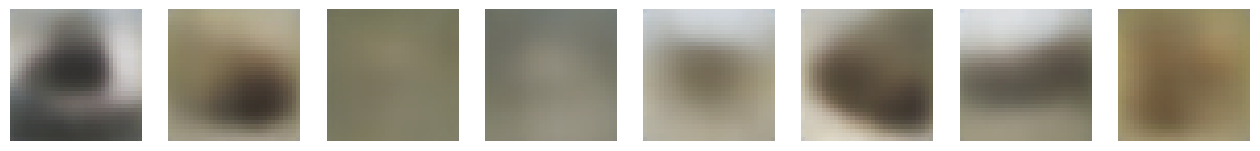

Epoch 006: Train ELBO -440.065 Test ELBO -438.202


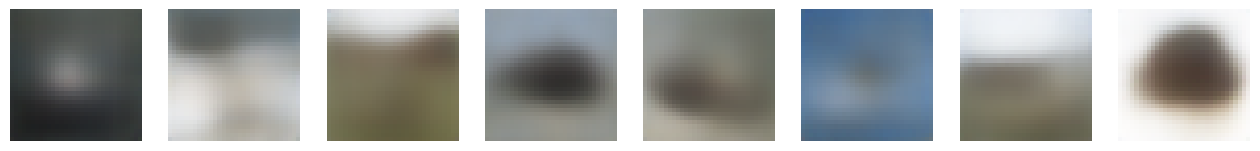

Epoch 007: Train ELBO -437.145 Test ELBO -434.433


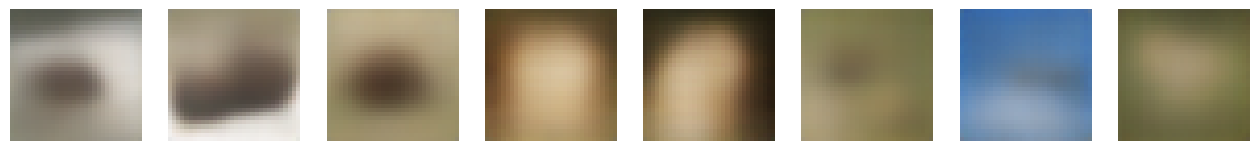

Epoch 008: Train ELBO -432.808 Test ELBO -430.625


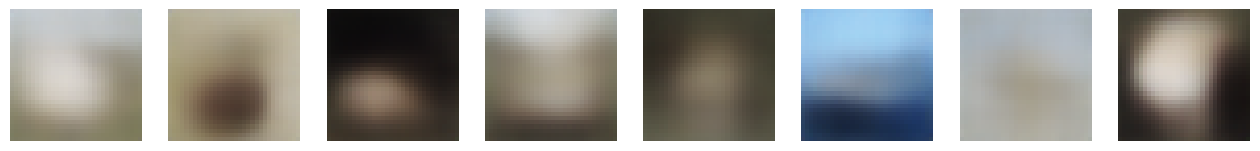

Epoch 009: Train ELBO -429.510 Test ELBO -428.644


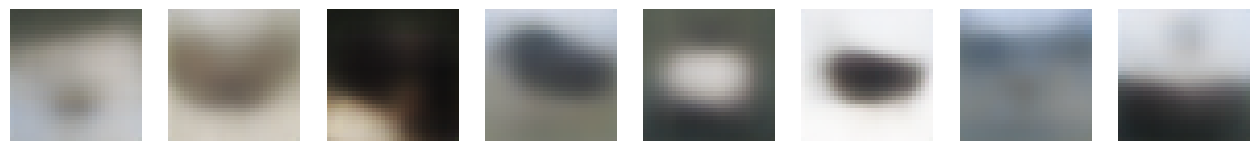

Epoch 010: Train ELBO -428.164 Test ELBO -427.930


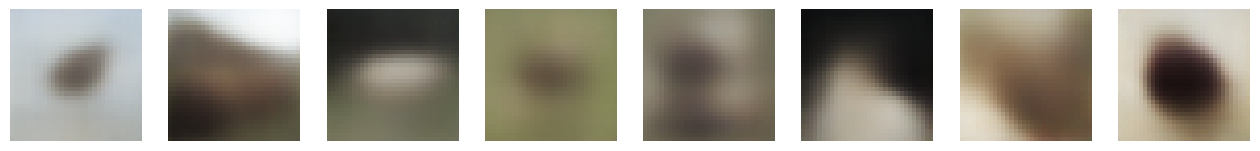

Epoch 011: Train ELBO -426.894 Test ELBO -425.406


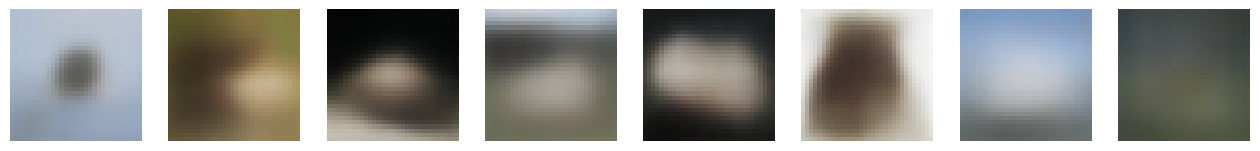

Epoch 012: Train ELBO -425.881 Test ELBO -424.565


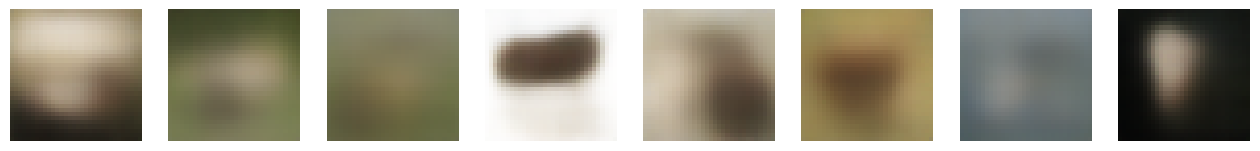

Epoch 013: Train ELBO -424.504 Test ELBO -422.629


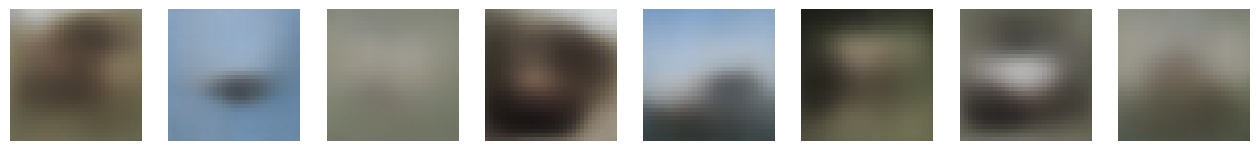

Epoch 014: Train ELBO -422.196 Test ELBO -421.372


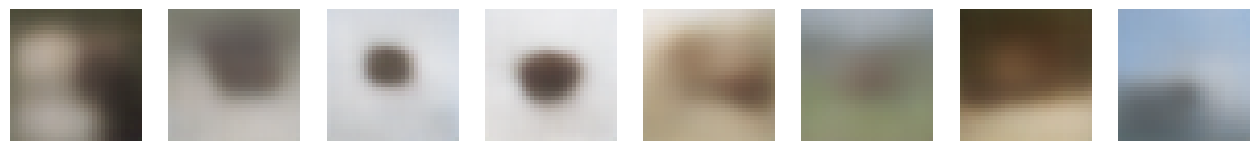

Epoch 015: Train ELBO -420.248 Test ELBO -420.491


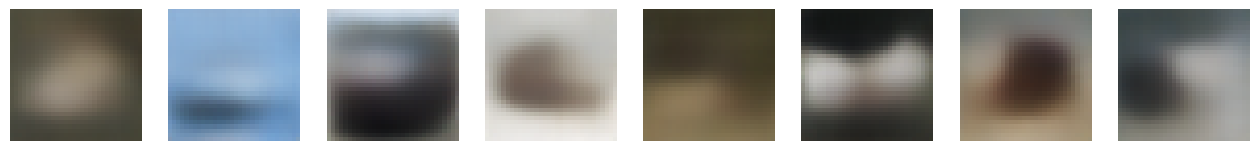

Epoch 016: Train ELBO -418.061 Test ELBO -416.551


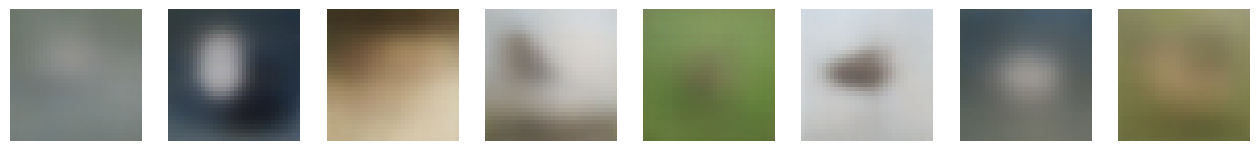

Epoch 017: Train ELBO -416.126 Test ELBO -415.263


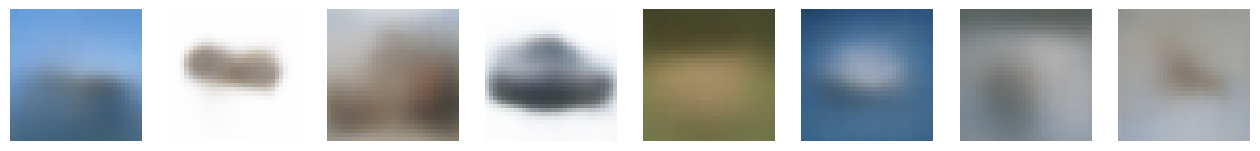

Epoch 018: Train ELBO -415.022 Test ELBO -413.713


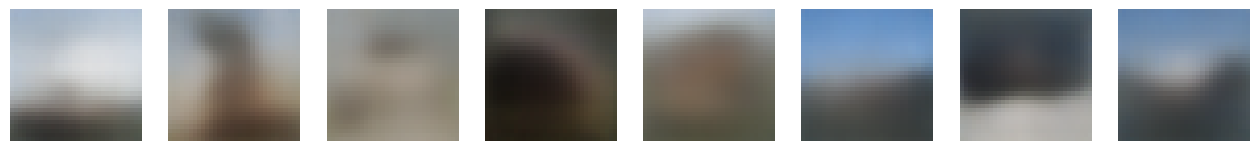

Epoch 019: Train ELBO -413.836 Test ELBO -412.495


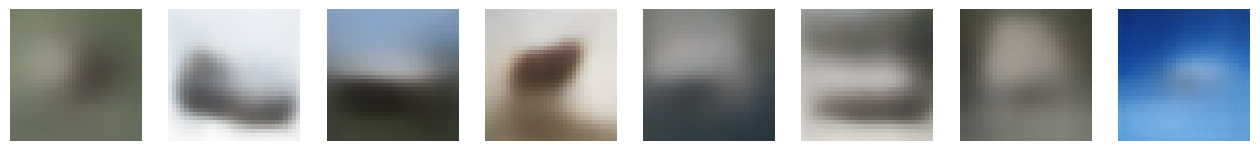

Epoch 020: Train ELBO -412.379 Test ELBO -412.847


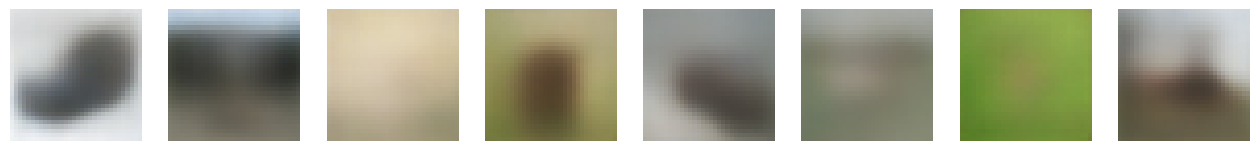

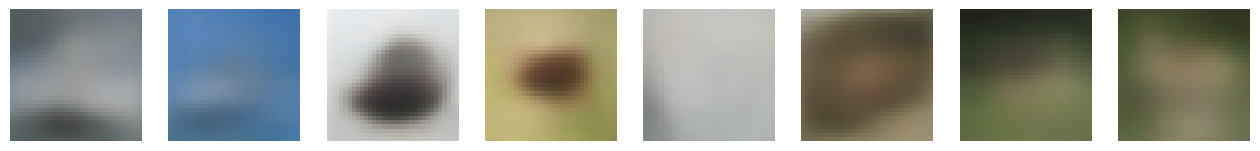


The same Eight random points from the latent space is made in to images after training



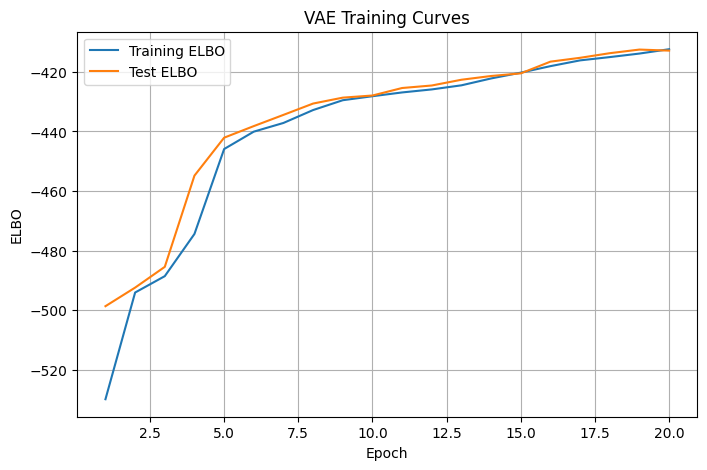

In [19]:
# train the model for multiple beta values from beta=1 to beta =5
for beta in range(1,6):
    latent_dimension=512
    learning_rate =1e-4
    epochs =20
    encoder1=Encoder(latent_dimension).to(device)
    decoder1=Decoder(latent_dimension).to(device)
    optimizer= torch.optim.Adam(list(encoder1.parameters())+list(decoder1.parameters()),lr=learning_rate)
    print(f"beta->{beta}")
    train_the_vae1(encoder1,decoder1,train_loader,test_loader,optimizer,epochs,latent_dimension,beta,device)

# The effect of β and Extended β training  on VAE behaviour

In this experiment, the model was  first trained  using β annealing technique,i.e gradually increasing  β from 0 to 1. During  the early stages (low β), the model prioritized reconstruction accuracy. The reconstructed images were  sharper  and retained more color intensity  and structural  detail because  the KL-divergence term had  limited influence. As β increased  towards 1,  the regularisation parameter effect progressively strengthened. The latent space  became  smoother and more structured, and interpolation between  latent points appeared more continuous. However, reconstruction  sharpness  gradually decreased as KL constraint  restricted the amount of information encoded in the latent variables

After reaching β=1, additional training was  conducted  using fixed values of β=1,2,3,4 and 5. As β increased beyond 1, the regularization  effect became significantly stronger. The KL divergence  term increasingly dominated the objective function, forcing the learned prosterior closer  to standard normal prior. This resulted in a higly organised  latent space with very smooth interpolations. However reconstruction quality degraded  noticably. Images  become progressively blurrier and  less detailed as β increased, indicating that the encoder  was constrained  from storing fine-grained information.

At higher β vales (4 or 5), over regularisation  was evident. The reconstruction  appeared overly smooth, with reduced  contrast  and weakened  object boundaries. This demonstrates that while  increasing β improves  latent space  regularity and encourages disentanglement, it comes at the cost of  reconstruction fidelity.

Overall the experiment confirm that β  increases, the strength of the regularization increases, leading to  smoother latent representations  but reduced image sharpness